In [6]:
# Global imports
import sys, os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import Counter, OrderedDict

%matplotlib inline 
#%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.style.use(['dark_background'])

import numpy as np
import json
import collections
from scipy import stats
import random
import math
from datetime import datetime
import csv
import h5py

# Local import
sys.path.insert(0, '../training/methods/')
# Import the neural network architectures:
from MLP import Net as MLP
from CNN import Net as CNN

sys.path.insert(0, '../training/src/')
from dataset import spectrum_dataset, splitDataLoader, ToTensor, Normalize

In [1]:
pwd

'/home/malavika/Documents/Research/assessment/evaluation'

# User-defined parameters

In [18]:
working_dir = "/home/malavika/Documents/Research/assessment/"
path_to_models = working_dir+'models/model1/'
path_to_datasets = working_dir+"datasets/"


dl_arch = 'mlp'
nb_layer = 2
dataset_size = 221852
optimizer_name =  "Adam" 
batch_size = 128 
LEARNING_RATE = '0.001' 
nb_epoch = 500
metric = 'bce'
split_train = '0.9'
layers = '2hl'
params = '6'
f = 371 + int(params)

test_dataset_size = 22185

In [4]:
model_name = 'model_'+str(dataset_size)+'spectrum_'+dl_arch+'_'+layers+'_bs'+str(batch_size)+'_lr'+\
    str(LEARNING_RATE)+'_'+str(nb_epoch)+'ep_opt'+str(optimizer_name)+'_split'+split_train+'_'+metric+'_'+params
model_name


'model_221852spectrum_mlp_2hl_bs128_lr0.001_500ep_optAdam_split0.9_bce_6'

# Display the training and validation losses

## Read the train/val losses

In [7]:
model_name = 'model_'+str(dataset_size)+'spectrum_'+dl_arch+'_'+layers+'_bs'+str(batch_size)+'_lr'+\
    str(LEARNING_RATE)+'_'+str(nb_epoch)+'ep_opt'+str(optimizer_name)+'_split'+split_train+'_'+metric+'_'+params

metrics_file = '../models/model1/'+model_name+'/metrics.json'

with open(metrics_file) as json_file:
    data = json.load(json_file)
    
#model_10000spectrum_mlp_bs32_lr1e-4_100ep_optAdam_split90_mse
#model_10000spectrum_cnn_bs128_lr1e-4_100ep_optAdam_split90_bce_1
#model_117882spectrum_mlp_bs128_lr1e-4_100ep_optAdam_split90_bce_1

# model_117882spectrum_mlp_2hl_bs128_lr0.001_500ep_optAdam_split0.9_bce_4

In [8]:
## reading from the csv file saved from the terminal

# c= path_to_models+model_name
# t=[]
# v=[]

# with open(c+'/logs_terminal.txt', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
#     for i, row in enumerate(spamreader):
#         if (i%4) == 0:
#             t.append(float(row[3]))
#         if (i-1)%4 ==0 :
#             v.append(float(row[3]))
        

## Plot the losses

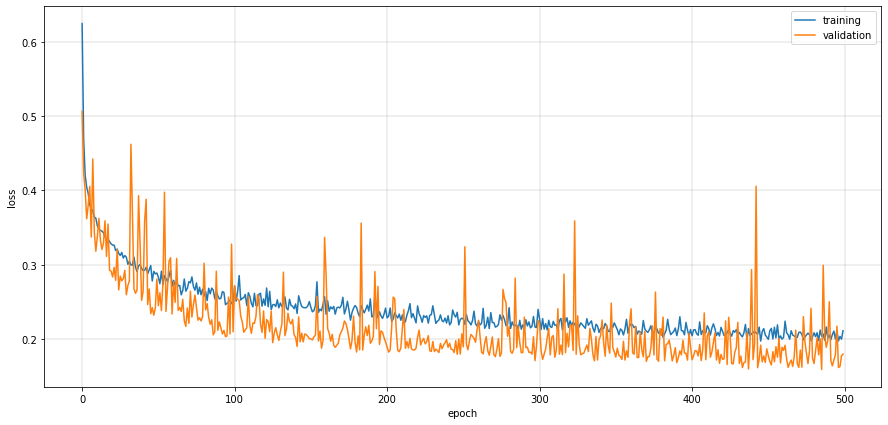

In [9]:
fig = plt.figure(1, figsize=(15,7))
plt.plot(data['train_loss'], label='training') # t
plt.plot(data['val_loss'], label='validation') # v
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.grid(linewidth=0.4)

In [10]:
print(np.min(data['train_loss']))   # t
print(np.min(data['val_loss']))   #  v

0.19740519727627387
0.15919093129762207


# Load the model

In [15]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(f, 100) 
        self.layer_2 = nn.Linear(100, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(100)
        self.batchnorm2 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [16]:
model = binaryClassification()

In [19]:
# Load model architecture:

model_file = path_to_models+ model_name+'/model.pth'

assert os.path.isfile(model_file), "{} does not exist".format(model_file)
print("Model file name: {}\n".format(model_file))

state_dict = torch.load(model_file, map_location='cpu')

new_state_dict = OrderedDict()

try:
    model.load_state_dict(state_dict)
except RuntimeError as e:
    print('Ignoring "' + str(e) + '"')

# model.load_state_dict(state_dict)

AssertionError: /home/malavika/Documents/Research/assessment/models/model1/model_221852spectrum_mlp_2hl_bs128_lr0.001_500ep_optAdam_split0.9_bce_6/model.pth does not exist

# Create the dataset object

We apply the same transformations to the test dataset than to the training/validation set

In [10]:
# Define name of the hdf5 file containing the test data:
test_file = path_to_datasets+"4params_test_bce_19k2.h5"

assert os.path.isfile(test_file), "{} does not exist".format(test_file)
print("Test dataset filename: {}".format(test_file))  

transfo = transforms.Compose([Normalize(), ToTensor()])

# Create the dataset object:xc
test_dataset = spectrum_dataset(path_to_file = test_file, 
                          size = test_dataset_size,
                          transform = transfo)

Test dataset filename: /home/malavika/Documents/Research/assessment/datasets/4params_test_bce_19k2.h5


# Perform predictions

In [11]:
with h5py.File(test_file, 'r') as f: 
    d = np.array(f.get('data'))
    l = np.array(f.get('labels'))
    # f.open('data', data= XT[:100], dtype=np.float32)
    # f.open('labels', data=labels[:100], dtype=np.float32)
f.close()

In [12]:
l

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [13]:
prediction_list = []
ratio_list = []
rmse_list = []
print(test_dataset_size)

for id in range(test_dataset_size):

    sample = test_dataset[id]

    ratio = sample['target'].numpy()
    density = sample['input'].unsqueeze(0)
    prediction = model(density).detach().numpy()[0]
    
    prediction_list.append(prediction)
    ratio_list.append(ratio)

37962


In [44]:
sample['target']

tensor([0.])

In [58]:
p= []
for i in range(test_dataset_size):
    print("id={}".format(i))
    if (prediction_list[i] > 0.5): 
        p.append(np.float32([1]))
    else: 
        p.append(np.float32([0]))
    print(p[i])
    print(ratio_list[i])
    print()

id=0
[1.]
[1.]

id=1
[1.]
[1.]

id=2
[1.]
[1.]

id=3
[1.]
[1.]

id=4
[1.]
[1.]

id=5
[1.]
[1.]

id=6
[1.]
[1.]

id=7
[1.]
[1.]

id=8
[1.]
[1.]

id=9
[1.]
[1.]

id=10
[1.]
[1.]

id=11
[1.]
[1.]

id=12
[1.]
[1.]

id=13
[1.]
[1.]

id=14
[1.]
[1.]

id=15
[1.]
[1.]

id=16
[1.]
[1.]

id=17
[1.]
[1.]

id=18
[1.]
[1.]

id=19
[0.]
[1.]

id=20
[1.]
[1.]

id=21
[1.]
[1.]

id=22
[1.]
[1.]

id=23
[1.]
[1.]

id=24
[1.]
[1.]

id=25
[1.]
[1.]

id=26
[1.]
[1.]

id=27
[1.]
[1.]

id=28
[1.]
[1.]

id=29
[1.]
[1.]

id=30
[1.]
[1.]

id=31
[1.]
[1.]

id=32
[1.]
[1.]

id=33
[1.]
[1.]

id=34
[1.]
[1.]

id=35
[0.]
[1.]

id=36
[1.]
[1.]

id=37
[1.]
[1.]

id=38
[1.]
[1.]

id=39
[1.]
[1.]

id=40
[1.]
[1.]

id=41
[1.]
[1.]

id=42
[1.]
[1.]

id=43
[1.]
[1.]

id=44
[0.]
[1.]

id=45
[1.]
[1.]

id=46
[1.]
[1.]

id=47
[1.]
[1.]

id=48
[1.]
[1.]

id=49
[1.]
[1.]

id=50
[1.]
[1.]

id=51
[1.]
[1.]

id=52
[1.]
[1.]

id=53
[1.]
[1.]

id=54
[1.]
[1.]

id=55
[1.]
[1.]

id=56
[1.]
[1.]

id=57
[1.]
[1.]

id=58
[1.]
[1.]

id=59
[

[1.]
[1.]

id=628
[1.]
[1.]

id=629
[1.]
[1.]

id=630
[1.]
[1.]

id=631
[1.]
[1.]

id=632
[1.]
[1.]

id=633
[1.]
[1.]

id=634
[1.]
[1.]

id=635
[1.]
[1.]

id=636
[1.]
[1.]

id=637
[1.]
[1.]

id=638
[1.]
[1.]

id=639
[0.]
[1.]

id=640
[1.]
[1.]

id=641
[1.]
[1.]

id=642
[1.]
[1.]

id=643
[1.]
[1.]

id=644
[1.]
[1.]

id=645
[1.]
[1.]

id=646
[1.]
[1.]

id=647
[1.]
[1.]

id=648
[1.]
[1.]

id=649
[1.]
[1.]

id=650
[1.]
[1.]

id=651
[1.]
[1.]

id=652
[1.]
[1.]

id=653
[1.]
[1.]

id=654
[1.]
[1.]

id=655
[1.]
[1.]

id=656
[1.]
[1.]

id=657
[1.]
[1.]

id=658
[1.]
[1.]

id=659
[1.]
[1.]

id=660
[1.]
[1.]

id=661
[1.]
[1.]

id=662
[1.]
[1.]

id=663
[1.]
[1.]

id=664
[1.]
[1.]

id=665
[1.]
[1.]

id=666
[1.]
[1.]

id=667
[1.]
[1.]

id=668
[1.]
[1.]

id=669
[1.]
[1.]

id=670
[1.]
[1.]

id=671
[1.]
[1.]

id=672
[0.]
[1.]

id=673
[1.]
[1.]

id=674
[1.]
[1.]

id=675
[1.]
[1.]

id=676
[1.]
[1.]

id=677
[1.]
[1.]

id=678
[1.]
[1.]

id=679
[1.]
[1.]

id=680
[1.]
[1.]

id=681
[1.]
[1.]

id=682
[1.]
[1.]


[1.]

id=1244
[1.]
[1.]

id=1245
[1.]
[1.]

id=1246
[1.]
[1.]

id=1247
[1.]
[1.]

id=1248
[1.]
[1.]

id=1249
[1.]
[1.]

id=1250
[1.]
[1.]

id=1251
[1.]
[1.]

id=1252
[1.]
[1.]

id=1253
[1.]
[1.]

id=1254
[1.]
[1.]

id=1255
[1.]
[1.]

id=1256
[1.]
[1.]

id=1257
[1.]
[1.]

id=1258
[1.]
[1.]

id=1259
[1.]
[1.]

id=1260
[1.]
[1.]

id=1261
[1.]
[1.]

id=1262
[1.]
[1.]

id=1263
[1.]
[1.]

id=1264
[1.]
[1.]

id=1265
[1.]
[1.]

id=1266
[1.]
[1.]

id=1267
[1.]
[1.]

id=1268
[1.]
[1.]

id=1269
[1.]
[1.]

id=1270
[1.]
[1.]

id=1271
[1.]
[1.]

id=1272
[1.]
[1.]

id=1273
[1.]
[1.]

id=1274
[1.]
[1.]

id=1275
[0.]
[1.]

id=1276
[1.]
[1.]

id=1277
[1.]
[1.]

id=1278
[1.]
[1.]

id=1279
[1.]
[1.]

id=1280
[1.]
[1.]

id=1281
[0.]
[1.]

id=1282
[0.]
[1.]

id=1283
[1.]
[1.]

id=1284
[1.]
[1.]

id=1285
[1.]
[1.]

id=1286
[1.]
[1.]

id=1287
[1.]
[1.]

id=1288
[1.]
[1.]

id=1289
[1.]
[1.]

id=1290
[1.]
[1.]

id=1291
[1.]
[1.]

id=1292
[1.]
[1.]

id=1293
[1.]
[1.]

id=1294
[1.]
[1.]

id=1295
[1.]
[1.]

id=129

[1.]
[1.]

id=1895
[1.]
[1.]

id=1896
[1.]
[1.]

id=1897
[1.]
[1.]

id=1898
[1.]
[1.]

id=1899
[1.]
[1.]

id=1900
[1.]
[1.]

id=1901
[1.]
[1.]

id=1902
[1.]
[1.]

id=1903
[1.]
[1.]

id=1904
[1.]
[1.]

id=1905
[1.]
[1.]

id=1906
[1.]
[1.]

id=1907
[1.]
[1.]

id=1908
[1.]
[1.]

id=1909
[1.]
[1.]

id=1910
[1.]
[1.]

id=1911
[1.]
[1.]

id=1912
[1.]
[1.]

id=1913
[1.]
[1.]

id=1914
[1.]
[1.]

id=1915
[1.]
[1.]

id=1916
[1.]
[1.]

id=1917
[1.]
[1.]

id=1918
[1.]
[1.]

id=1919
[1.]
[1.]

id=1920
[1.]
[1.]

id=1921
[1.]
[1.]

id=1922
[1.]
[1.]

id=1923
[1.]
[1.]

id=1924
[1.]
[1.]

id=1925
[1.]
[1.]

id=1926
[1.]
[1.]

id=1927
[1.]
[1.]

id=1928
[1.]
[1.]

id=1929
[1.]
[1.]

id=1930
[1.]
[1.]

id=1931
[1.]
[1.]

id=1932
[1.]
[1.]

id=1933
[1.]
[1.]

id=1934
[1.]
[1.]

id=1935
[1.]
[1.]

id=1936
[1.]
[1.]

id=1937
[1.]
[1.]

id=1938
[1.]
[1.]

id=1939
[1.]
[1.]

id=1940
[1.]
[1.]

id=1941
[1.]
[1.]

id=1942
[1.]
[1.]

id=1943
[1.]
[1.]

id=1944
[1.]
[1.]

id=1945
[1.]
[1.]

id=1946
[1.]
[1.]

i

[1.]

id=2468
[1.]
[1.]

id=2469
[1.]
[1.]

id=2470
[1.]
[1.]

id=2471
[1.]
[1.]

id=2472
[1.]
[1.]

id=2473
[1.]
[1.]

id=2474
[1.]
[1.]

id=2475
[1.]
[1.]

id=2476
[1.]
[1.]

id=2477
[1.]
[1.]

id=2478
[1.]
[1.]

id=2479
[1.]
[1.]

id=2480
[1.]
[1.]

id=2481
[1.]
[1.]

id=2482
[1.]
[1.]

id=2483
[1.]
[1.]

id=2484
[1.]
[1.]

id=2485
[1.]
[1.]

id=2486
[1.]
[1.]

id=2487
[1.]
[1.]

id=2488
[1.]
[1.]

id=2489
[1.]
[1.]

id=2490
[0.]
[1.]

id=2491
[1.]
[1.]

id=2492
[1.]
[1.]

id=2493
[1.]
[1.]

id=2494
[1.]
[1.]

id=2495
[1.]
[1.]

id=2496
[1.]
[1.]

id=2497
[1.]
[1.]

id=2498
[1.]
[1.]

id=2499
[1.]
[1.]

id=2500
[1.]
[1.]

id=2501
[1.]
[1.]

id=2502
[1.]
[1.]

id=2503
[1.]
[1.]

id=2504
[0.]
[1.]

id=2505
[1.]
[1.]

id=2506
[1.]
[1.]

id=2507
[1.]
[1.]

id=2508
[1.]
[1.]

id=2509
[1.]
[1.]

id=2510
[1.]
[1.]

id=2511
[1.]
[1.]

id=2512
[1.]
[1.]

id=2513
[1.]
[1.]

id=2514
[1.]
[1.]

id=2515
[1.]
[1.]

id=2516
[1.]
[1.]

id=2517
[1.]
[1.]

id=2518
[1.]
[1.]

id=2519
[1.]
[1.]

id=252

[1.]
[1.]

id=3092
[1.]
[1.]

id=3093
[1.]
[1.]

id=3094
[1.]
[1.]

id=3095
[1.]
[1.]

id=3096
[1.]
[1.]

id=3097
[1.]
[1.]

id=3098
[1.]
[1.]

id=3099
[1.]
[1.]

id=3100
[1.]
[1.]

id=3101
[1.]
[1.]

id=3102
[1.]
[1.]

id=3103
[1.]
[1.]

id=3104
[1.]
[1.]

id=3105
[1.]
[1.]

id=3106
[1.]
[1.]

id=3107
[1.]
[1.]

id=3108
[1.]
[1.]

id=3109
[1.]
[1.]

id=3110
[0.]
[1.]

id=3111
[1.]
[1.]

id=3112
[1.]
[1.]

id=3113
[1.]
[1.]

id=3114
[1.]
[1.]

id=3115
[1.]
[1.]

id=3116
[1.]
[1.]

id=3117
[1.]
[1.]

id=3118
[1.]
[1.]

id=3119
[1.]
[1.]

id=3120
[1.]
[1.]

id=3121
[1.]
[1.]

id=3122
[1.]
[1.]

id=3123
[1.]
[1.]

id=3124
[1.]
[1.]

id=3125
[1.]
[1.]

id=3126
[1.]
[1.]

id=3127
[1.]
[1.]

id=3128
[1.]
[1.]

id=3129
[1.]
[1.]

id=3130
[1.]
[1.]

id=3131
[1.]
[1.]

id=3132
[1.]
[1.]

id=3133
[1.]
[1.]

id=3134
[1.]
[1.]

id=3135
[1.]
[1.]

id=3136
[1.]
[1.]

id=3137
[1.]
[1.]

id=3138
[1.]
[1.]

id=3139
[1.]
[1.]

id=3140
[1.]
[1.]

id=3141
[1.]
[1.]

id=3142
[1.]
[1.]

id=3143
[1.]
[1.]

i

[1.]

id=3732
[1.]
[1.]

id=3733
[1.]
[1.]

id=3734
[1.]
[1.]

id=3735
[1.]
[1.]

id=3736
[1.]
[1.]

id=3737
[1.]
[1.]

id=3738
[1.]
[1.]

id=3739
[1.]
[1.]

id=3740
[1.]
[1.]

id=3741
[1.]
[1.]

id=3742
[1.]
[1.]

id=3743
[1.]
[1.]

id=3744
[1.]
[1.]

id=3745
[1.]
[1.]

id=3746
[1.]
[1.]

id=3747
[1.]
[1.]

id=3748
[1.]
[1.]

id=3749
[1.]
[1.]

id=3750
[1.]
[1.]

id=3751
[1.]
[1.]

id=3752
[1.]
[1.]

id=3753
[1.]
[1.]

id=3754
[1.]
[1.]

id=3755
[0.]
[1.]

id=3756
[1.]
[1.]

id=3757
[1.]
[1.]

id=3758
[1.]
[1.]

id=3759
[1.]
[1.]

id=3760
[1.]
[1.]

id=3761
[1.]
[1.]

id=3762
[1.]
[1.]

id=3763
[1.]
[1.]

id=3764
[1.]
[1.]

id=3765
[1.]
[1.]

id=3766
[1.]
[1.]

id=3767
[1.]
[1.]

id=3768
[0.]
[1.]

id=3769
[1.]
[1.]

id=3770
[1.]
[1.]

id=3771
[0.]
[1.]

id=3772
[1.]
[1.]

id=3773
[0.]
[1.]

id=3774
[1.]
[1.]

id=3775
[1.]
[1.]

id=3776
[1.]
[1.]

id=3777
[1.]
[1.]

id=3778
[1.]
[1.]

id=3779
[0.]
[1.]

id=3780
[1.]
[1.]

id=3781
[1.]
[1.]

id=3782
[1.]
[1.]

id=3783
[1.]
[1.]

id=378

[1.]
[1.]

id=4345
[1.]
[1.]

id=4346
[1.]
[1.]

id=4347
[0.]
[1.]

id=4348
[1.]
[1.]

id=4349
[1.]
[1.]

id=4350
[1.]
[1.]

id=4351
[1.]
[1.]

id=4352
[1.]
[1.]

id=4353
[1.]
[1.]

id=4354
[1.]
[1.]

id=4355
[1.]
[1.]

id=4356
[1.]
[1.]

id=4357
[1.]
[1.]

id=4358
[1.]
[1.]

id=4359
[1.]
[1.]

id=4360
[1.]
[1.]

id=4361
[1.]
[1.]

id=4362
[1.]
[1.]

id=4363
[1.]
[1.]

id=4364
[1.]
[1.]

id=4365
[1.]
[1.]

id=4366
[1.]
[1.]

id=4367
[1.]
[1.]

id=4368
[1.]
[1.]

id=4369
[1.]
[1.]

id=4370
[1.]
[1.]

id=4371
[1.]
[1.]

id=4372
[1.]
[1.]

id=4373
[1.]
[1.]

id=4374
[1.]
[1.]

id=4375
[1.]
[1.]

id=4376
[1.]
[1.]

id=4377
[0.]
[1.]

id=4378
[1.]
[1.]

id=4379
[1.]
[1.]

id=4380
[1.]
[1.]

id=4381
[1.]
[1.]

id=4382
[1.]
[1.]

id=4383
[1.]
[1.]

id=4384
[1.]
[1.]

id=4385
[1.]
[1.]

id=4386
[1.]
[1.]

id=4387
[1.]
[1.]

id=4388
[1.]
[1.]

id=4389
[1.]
[1.]

id=4390
[1.]
[1.]

id=4391
[1.]
[1.]

id=4392
[1.]
[1.]

id=4393
[1.]
[1.]

id=4394
[1.]
[1.]

id=4395
[1.]
[1.]

id=4396
[1.]
[1.]

i

[1.]
[1.]

id=4964
[1.]
[1.]

id=4965
[1.]
[1.]

id=4966
[1.]
[1.]

id=4967
[1.]
[1.]

id=4968
[1.]
[1.]

id=4969
[1.]
[1.]

id=4970
[1.]
[1.]

id=4971
[1.]
[1.]

id=4972
[1.]
[1.]

id=4973
[1.]
[1.]

id=4974
[1.]
[1.]

id=4975
[1.]
[1.]

id=4976
[1.]
[1.]

id=4977
[1.]
[1.]

id=4978
[1.]
[1.]

id=4979
[1.]
[1.]

id=4980
[1.]
[1.]

id=4981
[1.]
[1.]

id=4982
[1.]
[1.]

id=4983
[1.]
[1.]

id=4984
[1.]
[1.]

id=4985
[1.]
[1.]

id=4986
[1.]
[1.]

id=4987
[1.]
[1.]

id=4988
[1.]
[1.]

id=4989
[1.]
[1.]

id=4990
[1.]
[1.]

id=4991
[1.]
[1.]

id=4992
[1.]
[1.]

id=4993
[1.]
[1.]

id=4994
[1.]
[1.]

id=4995
[1.]
[1.]

id=4996
[1.]
[1.]

id=4997
[1.]
[1.]

id=4998
[1.]
[1.]

id=4999
[1.]
[1.]

id=5000
[1.]
[1.]

id=5001
[1.]
[1.]

id=5002
[1.]
[1.]

id=5003
[1.]
[1.]

id=5004
[1.]
[1.]

id=5005
[1.]
[1.]

id=5006
[1.]
[1.]

id=5007
[1.]
[1.]

id=5008
[1.]
[1.]

id=5009
[1.]
[1.]

id=5010
[1.]
[1.]

id=5011
[1.]
[1.]

id=5012
[0.]
[1.]

id=5013
[1.]
[1.]

id=5014
[1.]
[1.]

id=5015
[1.]
[1.]

i

[1.]

id=5561
[1.]
[1.]

id=5562
[1.]
[1.]

id=5563
[1.]
[1.]

id=5564
[1.]
[1.]

id=5565
[1.]
[1.]

id=5566
[1.]
[1.]

id=5567
[1.]
[1.]

id=5568
[1.]
[1.]

id=5569
[1.]
[1.]

id=5570
[1.]
[1.]

id=5571
[1.]
[1.]

id=5572
[1.]
[1.]

id=5573
[0.]
[1.]

id=5574
[1.]
[1.]

id=5575
[1.]
[1.]

id=5576
[1.]
[1.]

id=5577
[1.]
[1.]

id=5578
[1.]
[1.]

id=5579
[1.]
[1.]

id=5580
[1.]
[1.]

id=5581
[1.]
[1.]

id=5582
[1.]
[1.]

id=5583
[1.]
[1.]

id=5584
[1.]
[1.]

id=5585
[1.]
[1.]

id=5586
[1.]
[1.]

id=5587
[1.]
[1.]

id=5588
[1.]
[1.]

id=5589
[1.]
[1.]

id=5590
[1.]
[1.]

id=5591
[1.]
[1.]

id=5592
[1.]
[1.]

id=5593
[1.]
[1.]

id=5594
[1.]
[1.]

id=5595
[1.]
[1.]

id=5596
[1.]
[1.]

id=5597
[1.]
[1.]

id=5598
[1.]
[1.]

id=5599
[1.]
[1.]

id=5600
[1.]
[1.]

id=5601
[1.]
[1.]

id=5602
[1.]
[1.]

id=5603
[1.]
[1.]

id=5604
[1.]
[1.]

id=5605
[1.]
[1.]

id=5606
[1.]
[1.]

id=5607
[1.]
[1.]

id=5608
[1.]
[1.]

id=5609
[1.]
[1.]

id=5610
[1.]
[1.]

id=5611
[1.]
[1.]

id=5612
[1.]
[1.]

id=561


id=6112
[1.]
[1.]

id=6113
[1.]
[1.]

id=6114
[1.]
[1.]

id=6115
[1.]
[1.]

id=6116
[1.]
[1.]

id=6117
[1.]
[1.]

id=6118
[1.]
[1.]

id=6119
[1.]
[1.]

id=6120
[1.]
[1.]

id=6121
[1.]
[1.]

id=6122
[0.]
[1.]

id=6123
[1.]
[1.]

id=6124
[1.]
[1.]

id=6125
[1.]
[1.]

id=6126
[1.]
[1.]

id=6127
[1.]
[1.]

id=6128
[1.]
[1.]

id=6129
[1.]
[1.]

id=6130
[1.]
[1.]

id=6131
[1.]
[1.]

id=6132
[1.]
[1.]

id=6133
[1.]
[1.]

id=6134
[1.]
[1.]

id=6135
[1.]
[1.]

id=6136
[1.]
[1.]

id=6137
[1.]
[1.]

id=6138
[1.]
[1.]

id=6139
[1.]
[1.]

id=6140
[1.]
[1.]

id=6141
[1.]
[1.]

id=6142
[1.]
[1.]

id=6143
[1.]
[1.]

id=6144
[1.]
[1.]

id=6145
[1.]
[1.]

id=6146
[1.]
[1.]

id=6147
[1.]
[1.]

id=6148
[1.]
[1.]

id=6149
[1.]
[1.]

id=6150
[1.]
[1.]

id=6151
[1.]
[1.]

id=6152
[1.]
[1.]

id=6153
[1.]
[1.]

id=6154
[1.]
[1.]

id=6155
[1.]
[1.]

id=6156
[1.]
[1.]

id=6157
[1.]
[1.]

id=6158
[1.]
[1.]

id=6159
[1.]
[1.]

id=6160
[1.]
[1.]

id=6161
[1.]
[1.]

id=6162
[1.]
[1.]

id=6163
[0.]
[1.]

id=6164
[1.

[1.]
[1.]

id=6736
[1.]
[1.]

id=6737
[1.]
[1.]

id=6738
[1.]
[1.]

id=6739
[1.]
[1.]

id=6740
[1.]
[1.]

id=6741
[1.]
[1.]

id=6742
[1.]
[1.]

id=6743
[1.]
[1.]

id=6744
[1.]
[1.]

id=6745
[1.]
[1.]

id=6746
[1.]
[1.]

id=6747
[1.]
[1.]

id=6748
[1.]
[1.]

id=6749
[1.]
[1.]

id=6750
[1.]
[1.]

id=6751
[1.]
[1.]

id=6752
[1.]
[1.]

id=6753
[1.]
[1.]

id=6754
[1.]
[1.]

id=6755
[1.]
[1.]

id=6756
[1.]
[1.]

id=6757
[1.]
[1.]

id=6758
[1.]
[1.]

id=6759
[0.]
[1.]

id=6760
[1.]
[1.]

id=6761
[1.]
[1.]

id=6762
[1.]
[1.]

id=6763
[1.]
[1.]

id=6764
[0.]
[1.]

id=6765
[1.]
[1.]

id=6766
[1.]
[1.]

id=6767
[1.]
[1.]

id=6768
[1.]
[1.]

id=6769
[1.]
[1.]

id=6770
[1.]
[1.]

id=6771
[1.]
[1.]

id=6772
[1.]
[1.]

id=6773
[1.]
[1.]

id=6774
[1.]
[1.]

id=6775
[1.]
[1.]

id=6776
[1.]
[1.]

id=6777
[1.]
[1.]

id=6778
[0.]
[1.]

id=6779
[1.]
[1.]

id=6780
[1.]
[1.]

id=6781
[1.]
[1.]

id=6782
[1.]
[1.]

id=6783
[1.]
[1.]

id=6784
[1.]
[1.]

id=6785
[1.]
[1.]

id=6786
[1.]
[1.]

id=6787
[1.]
[1.]

i

[1.]

id=7396
[1.]
[1.]

id=7397
[1.]
[1.]

id=7398
[0.]
[1.]

id=7399
[1.]
[1.]

id=7400
[1.]
[1.]

id=7401
[1.]
[1.]

id=7402
[1.]
[1.]

id=7403
[1.]
[1.]

id=7404
[1.]
[1.]

id=7405
[1.]
[1.]

id=7406
[1.]
[1.]

id=7407
[1.]
[1.]

id=7408
[1.]
[1.]

id=7409
[1.]
[1.]

id=7410
[1.]
[1.]

id=7411
[1.]
[1.]

id=7412
[1.]
[1.]

id=7413
[1.]
[1.]

id=7414
[1.]
[1.]

id=7415
[1.]
[1.]

id=7416
[1.]
[1.]

id=7417
[0.]
[1.]

id=7418
[0.]
[1.]

id=7419
[1.]
[1.]

id=7420
[1.]
[1.]

id=7421
[1.]
[1.]

id=7422
[1.]
[1.]

id=7423
[0.]
[1.]

id=7424
[1.]
[1.]

id=7425
[1.]
[1.]

id=7426
[1.]
[1.]

id=7427
[1.]
[1.]

id=7428
[1.]
[1.]

id=7429
[1.]
[1.]

id=7430
[1.]
[1.]

id=7431
[1.]
[1.]

id=7432
[1.]
[1.]

id=7433
[1.]
[1.]

id=7434
[1.]
[1.]

id=7435
[1.]
[1.]

id=7436
[1.]
[1.]

id=7437
[1.]
[1.]

id=7438
[1.]
[1.]

id=7439
[1.]
[1.]

id=7440
[1.]
[1.]

id=7441
[1.]
[1.]

id=7442
[0.]
[1.]

id=7443
[1.]
[1.]

id=7444
[1.]
[1.]

id=7445
[1.]
[1.]

id=7446
[1.]
[1.]

id=7447
[1.]
[1.]

id=744

[0.]
[1.]

id=7992
[1.]
[1.]

id=7993
[1.]
[1.]

id=7994
[1.]
[1.]

id=7995
[1.]
[1.]

id=7996
[1.]
[1.]

id=7997
[1.]
[1.]

id=7998
[1.]
[1.]

id=7999
[1.]
[1.]

id=8000
[1.]
[1.]

id=8001
[0.]
[1.]

id=8002
[1.]
[1.]

id=8003
[1.]
[1.]

id=8004
[1.]
[1.]

id=8005
[1.]
[1.]

id=8006
[1.]
[1.]

id=8007
[1.]
[1.]

id=8008
[1.]
[1.]

id=8009
[0.]
[1.]

id=8010
[1.]
[1.]

id=8011
[1.]
[1.]

id=8012
[1.]
[1.]

id=8013
[1.]
[1.]

id=8014
[1.]
[1.]

id=8015
[1.]
[1.]

id=8016
[1.]
[1.]

id=8017
[1.]
[1.]

id=8018
[1.]
[1.]

id=8019
[1.]
[1.]

id=8020
[1.]
[1.]

id=8021
[1.]
[1.]

id=8022
[0.]
[1.]

id=8023
[1.]
[1.]

id=8024
[1.]
[1.]

id=8025
[0.]
[1.]

id=8026
[1.]
[1.]

id=8027
[1.]
[1.]

id=8028
[1.]
[1.]

id=8029
[1.]
[1.]

id=8030
[1.]
[1.]

id=8031
[1.]
[1.]

id=8032
[1.]
[1.]

id=8033
[1.]
[1.]

id=8034
[1.]
[1.]

id=8035
[1.]
[1.]

id=8036
[1.]
[1.]

id=8037
[1.]
[1.]

id=8038
[1.]
[1.]

id=8039
[1.]
[1.]

id=8040
[1.]
[1.]

id=8041
[1.]
[1.]

id=8042
[1.]
[1.]

id=8043
[1.]
[1.]

i

[1.]
[1.]

id=8607
[1.]
[1.]

id=8608
[1.]
[1.]

id=8609
[1.]
[1.]

id=8610
[1.]
[1.]

id=8611
[1.]
[1.]

id=8612
[1.]
[1.]

id=8613
[1.]
[1.]

id=8614
[1.]
[1.]

id=8615
[1.]
[1.]

id=8616
[1.]
[1.]

id=8617
[1.]
[1.]

id=8618
[1.]
[1.]

id=8619
[1.]
[1.]

id=8620
[1.]
[1.]

id=8621
[1.]
[1.]

id=8622
[1.]
[1.]

id=8623
[1.]
[1.]

id=8624
[1.]
[1.]

id=8625
[1.]
[1.]

id=8626
[1.]
[1.]

id=8627
[1.]
[1.]

id=8628
[1.]
[1.]

id=8629
[1.]
[1.]

id=8630
[1.]
[1.]

id=8631
[1.]
[1.]

id=8632
[1.]
[1.]

id=8633
[1.]
[1.]

id=8634
[1.]
[1.]

id=8635
[1.]
[1.]

id=8636
[1.]
[1.]

id=8637
[1.]
[1.]

id=8638
[1.]
[1.]

id=8639
[1.]
[1.]

id=8640
[1.]
[1.]

id=8641
[1.]
[1.]

id=8642
[1.]
[1.]

id=8643
[0.]
[1.]

id=8644
[1.]
[1.]

id=8645
[0.]
[1.]

id=8646
[1.]
[1.]

id=8647
[1.]
[1.]

id=8648
[1.]
[1.]

id=8649
[1.]
[1.]

id=8650
[1.]
[1.]

id=8651
[1.]
[1.]

id=8652
[1.]
[1.]

id=8653
[1.]
[1.]

id=8654
[1.]
[1.]

id=8655
[0.]
[1.]

id=8656
[1.]
[1.]

id=8657
[1.]
[1.]

id=8658
[1.]
[1.]

i

[1.]
[1.]

id=9245
[1.]
[1.]

id=9246
[1.]
[1.]

id=9247
[1.]
[1.]

id=9248
[1.]
[1.]

id=9249
[1.]
[1.]

id=9250
[1.]
[1.]

id=9251
[1.]
[1.]

id=9252
[1.]
[1.]

id=9253
[1.]
[1.]

id=9254
[1.]
[1.]

id=9255
[1.]
[1.]

id=9256
[1.]
[1.]

id=9257
[1.]
[1.]

id=9258
[1.]
[1.]

id=9259
[1.]
[1.]

id=9260
[0.]
[1.]

id=9261
[1.]
[1.]

id=9262
[1.]
[1.]

id=9263
[1.]
[1.]

id=9264
[1.]
[1.]

id=9265
[1.]
[1.]

id=9266
[1.]
[1.]

id=9267
[1.]
[1.]

id=9268
[1.]
[1.]

id=9269
[1.]
[1.]

id=9270
[1.]
[1.]

id=9271
[1.]
[1.]

id=9272
[1.]
[1.]

id=9273
[1.]
[1.]

id=9274
[0.]
[1.]

id=9275
[1.]
[1.]

id=9276
[1.]
[1.]

id=9277
[1.]
[1.]

id=9278
[1.]
[1.]

id=9279
[1.]
[1.]

id=9280
[1.]
[1.]

id=9281
[1.]
[1.]

id=9282
[1.]
[1.]

id=9283
[1.]
[1.]

id=9284
[1.]
[1.]

id=9285
[1.]
[1.]

id=9286
[1.]
[1.]

id=9287
[1.]
[1.]

id=9288
[1.]
[1.]

id=9289
[1.]
[1.]

id=9290
[1.]
[1.]

id=9291
[1.]
[1.]

id=9292
[1.]
[1.]

id=9293
[1.]
[1.]

id=9294
[1.]
[1.]

id=9295
[1.]
[1.]

id=9296
[1.]
[1.]

i

[1.]

id=9776
[1.]
[1.]

id=9777
[1.]
[1.]

id=9778
[1.]
[1.]

id=9779
[1.]
[1.]

id=9780
[1.]
[1.]

id=9781
[1.]
[1.]

id=9782
[1.]
[1.]

id=9783
[1.]
[1.]

id=9784
[1.]
[1.]

id=9785
[1.]
[1.]

id=9786
[1.]
[1.]

id=9787
[1.]
[1.]

id=9788
[1.]
[1.]

id=9789
[1.]
[1.]

id=9790
[1.]
[1.]

id=9791
[1.]
[1.]

id=9792
[1.]
[1.]

id=9793
[1.]
[1.]

id=9794
[1.]
[1.]

id=9795
[1.]
[1.]

id=9796
[1.]
[1.]

id=9797
[1.]
[1.]

id=9798
[1.]
[1.]

id=9799
[1.]
[1.]

id=9800
[1.]
[1.]

id=9801
[1.]
[1.]

id=9802
[1.]
[1.]

id=9803
[1.]
[1.]

id=9804
[1.]
[1.]

id=9805
[1.]
[1.]

id=9806
[1.]
[1.]

id=9807
[1.]
[1.]

id=9808
[1.]
[1.]

id=9809
[1.]
[1.]

id=9810
[1.]
[1.]

id=9811
[1.]
[1.]

id=9812
[1.]
[1.]

id=9813
[1.]
[1.]

id=9814
[1.]
[1.]

id=9815
[1.]
[1.]

id=9816
[1.]
[1.]

id=9817
[1.]
[1.]

id=9818
[1.]
[1.]

id=9819
[1.]
[1.]

id=9820
[0.]
[1.]

id=9821
[1.]
[1.]

id=9822
[0.]
[1.]

id=9823
[1.]
[1.]

id=9824
[1.]
[1.]

id=9825
[1.]
[1.]

id=9826
[1.]
[1.]

id=9827
[1.]
[1.]

id=982

[1.]

id=10345
[1.]
[1.]

id=10346
[1.]
[1.]

id=10347
[1.]
[1.]

id=10348
[1.]
[1.]

id=10349
[1.]
[1.]

id=10350
[1.]
[1.]

id=10351
[1.]
[1.]

id=10352
[1.]
[1.]

id=10353
[1.]
[1.]

id=10354
[1.]
[1.]

id=10355
[1.]
[1.]

id=10356
[1.]
[1.]

id=10357
[1.]
[1.]

id=10358
[1.]
[1.]

id=10359
[1.]
[1.]

id=10360
[1.]
[1.]

id=10361
[1.]
[1.]

id=10362
[1.]
[1.]

id=10363
[1.]
[1.]

id=10364
[1.]
[1.]

id=10365
[1.]
[1.]

id=10366
[1.]
[1.]

id=10367
[1.]
[1.]

id=10368
[1.]
[1.]

id=10369
[1.]
[1.]

id=10370
[1.]
[1.]

id=10371
[1.]
[1.]

id=10372
[1.]
[1.]

id=10373
[1.]
[1.]

id=10374
[1.]
[1.]

id=10375
[1.]
[1.]

id=10376
[1.]
[1.]

id=10377
[1.]
[1.]

id=10378
[1.]
[1.]

id=10379
[1.]
[1.]

id=10380
[1.]
[1.]

id=10381
[1.]
[1.]

id=10382
[1.]
[1.]

id=10383
[1.]
[1.]

id=10384
[0.]
[1.]

id=10385
[1.]
[1.]

id=10386
[1.]
[1.]

id=10387
[1.]
[1.]

id=10388
[1.]
[1.]

id=10389
[1.]
[1.]

id=10390
[1.]
[1.]

id=10391
[1.]
[1.]

id=10392
[1.]
[1.]

id=10393
[1.]
[1.]

id=10394
[0.]


[1.]

id=10932
[1.]
[1.]

id=10933
[1.]
[1.]

id=10934
[1.]
[1.]

id=10935
[1.]
[1.]

id=10936
[1.]
[1.]

id=10937
[1.]
[1.]

id=10938
[1.]
[1.]

id=10939
[1.]
[1.]

id=10940
[0.]
[1.]

id=10941
[1.]
[1.]

id=10942
[1.]
[1.]

id=10943
[1.]
[1.]

id=10944
[1.]
[1.]

id=10945
[1.]
[1.]

id=10946
[1.]
[1.]

id=10947
[1.]
[1.]

id=10948
[1.]
[1.]

id=10949
[1.]
[1.]

id=10950
[1.]
[1.]

id=10951
[1.]
[1.]

id=10952
[1.]
[1.]

id=10953
[1.]
[1.]

id=10954
[1.]
[1.]

id=10955
[1.]
[1.]

id=10956
[1.]
[1.]

id=10957
[1.]
[1.]

id=10958
[1.]
[1.]

id=10959
[1.]
[1.]

id=10960
[1.]
[1.]

id=10961
[1.]
[1.]

id=10962
[1.]
[1.]

id=10963
[1.]
[1.]

id=10964
[1.]
[1.]

id=10965
[1.]
[1.]

id=10966
[1.]
[1.]

id=10967
[1.]
[1.]

id=10968
[1.]
[1.]

id=10969
[1.]
[1.]

id=10970
[1.]
[1.]

id=10971
[1.]
[1.]

id=10972
[1.]
[1.]

id=10973
[1.]
[1.]

id=10974
[1.]
[1.]

id=10975
[1.]
[1.]

id=10976
[1.]
[1.]

id=10977
[1.]
[1.]

id=10978
[1.]
[1.]

id=10979
[1.]
[1.]

id=10980
[1.]
[1.]

id=10981
[1.]


[1.]
[1.]

id=11546
[1.]
[1.]

id=11547
[1.]
[1.]

id=11548
[1.]
[1.]

id=11549
[1.]
[1.]

id=11550
[1.]
[1.]

id=11551
[1.]
[1.]

id=11552
[1.]
[1.]

id=11553
[1.]
[1.]

id=11554
[1.]
[1.]

id=11555
[1.]
[1.]

id=11556
[1.]
[1.]

id=11557
[1.]
[1.]

id=11558
[1.]
[1.]

id=11559
[1.]
[1.]

id=11560
[1.]
[1.]

id=11561
[1.]
[1.]

id=11562
[1.]
[1.]

id=11563
[1.]
[1.]

id=11564
[1.]
[1.]

id=11565
[1.]
[1.]

id=11566
[1.]
[1.]

id=11567
[1.]
[1.]

id=11568
[1.]
[1.]

id=11569
[1.]
[1.]

id=11570
[1.]
[1.]

id=11571
[1.]
[1.]

id=11572
[0.]
[1.]

id=11573
[1.]
[1.]

id=11574
[1.]
[1.]

id=11575
[1.]
[1.]

id=11576
[1.]
[1.]

id=11577
[1.]
[1.]

id=11578
[1.]
[1.]

id=11579
[1.]
[1.]

id=11580
[1.]
[1.]

id=11581
[1.]
[1.]

id=11582
[1.]
[1.]

id=11583
[1.]
[1.]

id=11584
[1.]
[1.]

id=11585
[1.]
[1.]

id=11586
[1.]
[1.]

id=11587
[1.]
[1.]

id=11588
[1.]
[1.]

id=11589
[1.]
[1.]

id=11590
[1.]
[1.]

id=11591
[1.]
[1.]

id=11592
[1.]
[1.]

id=11593
[1.]
[1.]

id=11594
[1.]
[1.]

id=11595


[1.]
[1.]

id=12159
[1.]
[1.]

id=12160
[1.]
[1.]

id=12161
[1.]
[1.]

id=12162
[1.]
[1.]

id=12163
[1.]
[1.]

id=12164
[1.]
[1.]

id=12165
[1.]
[1.]

id=12166
[1.]
[1.]

id=12167
[1.]
[1.]

id=12168
[1.]
[1.]

id=12169
[1.]
[1.]

id=12170
[1.]
[1.]

id=12171
[1.]
[1.]

id=12172
[1.]
[1.]

id=12173
[1.]
[1.]

id=12174
[1.]
[1.]

id=12175
[1.]
[1.]

id=12176
[0.]
[1.]

id=12177
[1.]
[1.]

id=12178
[1.]
[1.]

id=12179
[1.]
[1.]

id=12180
[1.]
[1.]

id=12181
[1.]
[1.]

id=12182
[1.]
[1.]

id=12183
[1.]
[1.]

id=12184
[1.]
[1.]

id=12185
[1.]
[1.]

id=12186
[1.]
[1.]

id=12187
[1.]
[1.]

id=12188
[1.]
[1.]

id=12189
[1.]
[1.]

id=12190
[1.]
[1.]

id=12191
[1.]
[1.]

id=12192
[1.]
[1.]

id=12193
[1.]
[1.]

id=12194
[1.]
[1.]

id=12195
[1.]
[1.]

id=12196
[1.]
[1.]

id=12197
[1.]
[1.]

id=12198
[1.]
[1.]

id=12199
[1.]
[1.]

id=12200
[1.]
[1.]

id=12201
[1.]
[1.]

id=12202
[1.]
[1.]

id=12203
[1.]
[1.]

id=12204
[1.]
[1.]

id=12205
[1.]
[1.]

id=12206
[1.]
[1.]

id=12207
[1.]
[1.]

id=12208


[1.]

id=12791
[1.]
[1.]

id=12792
[1.]
[1.]

id=12793
[1.]
[1.]

id=12794
[1.]
[1.]

id=12795
[1.]
[1.]

id=12796
[1.]
[1.]

id=12797
[1.]
[1.]

id=12798
[1.]
[1.]

id=12799
[1.]
[1.]

id=12800
[1.]
[1.]

id=12801
[1.]
[1.]

id=12802
[1.]
[1.]

id=12803
[1.]
[1.]

id=12804
[1.]
[1.]

id=12805
[1.]
[1.]

id=12806
[1.]
[1.]

id=12807
[1.]
[1.]

id=12808
[1.]
[1.]

id=12809
[1.]
[1.]

id=12810
[1.]
[1.]

id=12811
[1.]
[1.]

id=12812
[1.]
[1.]

id=12813
[1.]
[1.]

id=12814
[1.]
[1.]

id=12815
[1.]
[1.]

id=12816
[1.]
[1.]

id=12817
[1.]
[1.]

id=12818
[1.]
[1.]

id=12819
[0.]
[1.]

id=12820
[1.]
[1.]

id=12821
[1.]
[1.]

id=12822
[1.]
[1.]

id=12823
[1.]
[1.]

id=12824
[1.]
[1.]

id=12825
[1.]
[1.]

id=12826
[1.]
[1.]

id=12827
[1.]
[1.]

id=12828
[1.]
[1.]

id=12829
[1.]
[1.]

id=12830
[0.]
[1.]

id=12831
[1.]
[1.]

id=12832
[1.]
[1.]

id=12833
[1.]
[1.]

id=12834
[1.]
[1.]

id=12835
[1.]
[1.]

id=12836
[1.]
[1.]

id=12837
[1.]
[1.]

id=12838
[1.]
[1.]

id=12839
[1.]
[1.]

id=12840
[1.]


[1.]
[1.]

id=13412
[1.]
[1.]

id=13413
[1.]
[1.]

id=13414
[1.]
[1.]

id=13415
[1.]
[1.]

id=13416
[1.]
[1.]

id=13417
[1.]
[1.]

id=13418
[1.]
[1.]

id=13419
[1.]
[1.]

id=13420
[1.]
[1.]

id=13421
[0.]
[1.]

id=13422
[1.]
[1.]

id=13423
[1.]
[1.]

id=13424
[1.]
[1.]

id=13425
[1.]
[1.]

id=13426
[1.]
[1.]

id=13427
[1.]
[1.]

id=13428
[1.]
[1.]

id=13429
[1.]
[1.]

id=13430
[1.]
[1.]

id=13431
[1.]
[1.]

id=13432
[1.]
[1.]

id=13433
[1.]
[1.]

id=13434
[1.]
[1.]

id=13435
[1.]
[1.]

id=13436
[1.]
[1.]

id=13437
[1.]
[1.]

id=13438
[1.]
[1.]

id=13439
[1.]
[1.]

id=13440
[1.]
[1.]

id=13441
[1.]
[1.]

id=13442
[1.]
[1.]

id=13443
[1.]
[1.]

id=13444
[1.]
[1.]

id=13445
[1.]
[1.]

id=13446
[1.]
[1.]

id=13447
[1.]
[1.]

id=13448
[1.]
[1.]

id=13449
[1.]
[1.]

id=13450
[1.]
[1.]

id=13451
[1.]
[1.]

id=13452
[1.]
[1.]

id=13453
[1.]
[1.]

id=13454
[1.]
[1.]

id=13455
[0.]
[1.]

id=13456
[1.]
[1.]

id=13457
[1.]
[1.]

id=13458
[1.]
[1.]

id=13459
[1.]
[1.]

id=13460
[1.]
[1.]

id=13461


[1.]
[1.]

id=14039
[1.]
[1.]

id=14040
[1.]
[1.]

id=14041
[1.]
[1.]

id=14042
[1.]
[1.]

id=14043
[1.]
[1.]

id=14044
[0.]
[1.]

id=14045
[1.]
[1.]

id=14046
[1.]
[1.]

id=14047
[1.]
[1.]

id=14048
[1.]
[1.]

id=14049
[1.]
[1.]

id=14050
[1.]
[1.]

id=14051
[1.]
[1.]

id=14052
[1.]
[1.]

id=14053
[1.]
[1.]

id=14054
[1.]
[1.]

id=14055
[1.]
[1.]

id=14056
[1.]
[1.]

id=14057
[1.]
[1.]

id=14058
[0.]
[1.]

id=14059
[1.]
[1.]

id=14060
[1.]
[1.]

id=14061
[1.]
[1.]

id=14062
[1.]
[1.]

id=14063
[1.]
[1.]

id=14064
[1.]
[1.]

id=14065
[1.]
[1.]

id=14066
[1.]
[1.]

id=14067
[1.]
[1.]

id=14068
[1.]
[1.]

id=14069
[1.]
[1.]

id=14070
[1.]
[1.]

id=14071
[1.]
[1.]

id=14072
[0.]
[1.]

id=14073
[1.]
[1.]

id=14074
[1.]
[1.]

id=14075
[1.]
[1.]

id=14076
[1.]
[1.]

id=14077
[1.]
[1.]

id=14078
[1.]
[1.]

id=14079
[1.]
[1.]

id=14080
[1.]
[1.]

id=14081
[1.]
[1.]

id=14082
[1.]
[1.]

id=14083
[1.]
[1.]

id=14084
[1.]
[1.]

id=14085
[1.]
[1.]

id=14086
[1.]
[1.]

id=14087
[1.]
[1.]

id=14088


[1.]
[1.]

id=14674
[1.]
[1.]

id=14675
[1.]
[1.]

id=14676
[1.]
[1.]

id=14677
[1.]
[1.]

id=14678
[1.]
[1.]

id=14679
[1.]
[1.]

id=14680
[1.]
[1.]

id=14681
[1.]
[1.]

id=14682
[1.]
[1.]

id=14683
[1.]
[1.]

id=14684
[1.]
[1.]

id=14685
[1.]
[1.]

id=14686
[1.]
[1.]

id=14687
[1.]
[1.]

id=14688
[1.]
[1.]

id=14689
[0.]
[1.]

id=14690
[1.]
[1.]

id=14691
[1.]
[1.]

id=14692
[1.]
[1.]

id=14693
[1.]
[1.]

id=14694
[1.]
[1.]

id=14695
[1.]
[1.]

id=14696
[1.]
[1.]

id=14697
[1.]
[1.]

id=14698
[1.]
[1.]

id=14699
[1.]
[1.]

id=14700
[1.]
[1.]

id=14701
[1.]
[1.]

id=14702
[1.]
[1.]

id=14703
[1.]
[1.]

id=14704
[1.]
[1.]

id=14705
[1.]
[1.]

id=14706
[1.]
[1.]

id=14707
[1.]
[1.]

id=14708
[1.]
[1.]

id=14709
[1.]
[1.]

id=14710
[1.]
[1.]

id=14711
[1.]
[1.]

id=14712
[1.]
[1.]

id=14713
[1.]
[1.]

id=14714
[1.]
[1.]

id=14715
[1.]
[1.]

id=14716
[1.]
[1.]

id=14717
[1.]
[1.]

id=14718
[1.]
[1.]

id=14719
[1.]
[1.]

id=14720
[1.]
[1.]

id=14721
[1.]
[1.]

id=14722
[1.]
[1.]

id=14723


[1.]

id=15294
[1.]
[1.]

id=15295
[1.]
[1.]

id=15296
[1.]
[1.]

id=15297
[1.]
[1.]

id=15298
[1.]
[1.]

id=15299
[1.]
[1.]

id=15300
[1.]
[1.]

id=15301
[1.]
[1.]

id=15302
[1.]
[1.]

id=15303
[1.]
[1.]

id=15304
[1.]
[1.]

id=15305
[1.]
[1.]

id=15306
[1.]
[1.]

id=15307
[1.]
[1.]

id=15308
[1.]
[1.]

id=15309
[1.]
[1.]

id=15310
[1.]
[1.]

id=15311
[0.]
[1.]

id=15312
[1.]
[1.]

id=15313
[1.]
[1.]

id=15314
[1.]
[1.]

id=15315
[1.]
[1.]

id=15316
[1.]
[1.]

id=15317
[1.]
[1.]

id=15318
[1.]
[1.]

id=15319
[1.]
[1.]

id=15320
[1.]
[1.]

id=15321
[1.]
[1.]

id=15322
[1.]
[1.]

id=15323
[1.]
[1.]

id=15324
[1.]
[1.]

id=15325
[1.]
[1.]

id=15326
[1.]
[1.]

id=15327
[1.]
[1.]

id=15328
[1.]
[1.]

id=15329
[1.]
[1.]

id=15330
[1.]
[1.]

id=15331
[1.]
[1.]

id=15332
[1.]
[1.]

id=15333
[1.]
[1.]

id=15334
[1.]
[1.]

id=15335
[1.]
[1.]

id=15336
[1.]
[1.]

id=15337
[1.]
[1.]

id=15338
[1.]
[1.]

id=15339
[1.]
[1.]

id=15340
[1.]
[1.]

id=15341
[1.]
[1.]

id=15342
[1.]
[1.]

id=15343
[1.]


[1.]

id=15943
[1.]
[1.]

id=15944
[1.]
[1.]

id=15945
[1.]
[1.]

id=15946
[0.]
[1.]

id=15947
[1.]
[1.]

id=15948
[1.]
[1.]

id=15949
[1.]
[1.]

id=15950
[1.]
[1.]

id=15951
[0.]
[1.]

id=15952
[1.]
[1.]

id=15953
[1.]
[1.]

id=15954
[1.]
[1.]

id=15955
[1.]
[1.]

id=15956
[1.]
[1.]

id=15957
[1.]
[1.]

id=15958
[1.]
[1.]

id=15959
[1.]
[1.]

id=15960
[0.]
[1.]

id=15961
[1.]
[1.]

id=15962
[1.]
[1.]

id=15963
[1.]
[1.]

id=15964
[1.]
[1.]

id=15965
[1.]
[1.]

id=15966
[1.]
[1.]

id=15967
[1.]
[1.]

id=15968
[1.]
[1.]

id=15969
[1.]
[1.]

id=15970
[1.]
[1.]

id=15971
[1.]
[1.]

id=15972
[1.]
[1.]

id=15973
[1.]
[1.]

id=15974
[1.]
[1.]

id=15975
[1.]
[1.]

id=15976
[1.]
[1.]

id=15977
[0.]
[1.]

id=15978
[1.]
[1.]

id=15979
[1.]
[1.]

id=15980
[1.]
[1.]

id=15981
[1.]
[1.]

id=15982
[1.]
[1.]

id=15983
[1.]
[1.]

id=15984
[1.]
[1.]

id=15985
[1.]
[1.]

id=15986
[1.]
[1.]

id=15987
[1.]
[1.]

id=15988
[1.]
[1.]

id=15989
[1.]
[1.]

id=15990
[1.]
[1.]

id=15991
[1.]
[1.]

id=15992
[1.]


[1.]

id=16594
[1.]
[1.]

id=16595
[1.]
[1.]

id=16596
[1.]
[1.]

id=16597
[1.]
[1.]

id=16598
[1.]
[1.]

id=16599
[1.]
[1.]

id=16600
[1.]
[1.]

id=16601
[1.]
[1.]

id=16602
[1.]
[1.]

id=16603
[1.]
[1.]

id=16604
[0.]
[1.]

id=16605
[1.]
[1.]

id=16606
[1.]
[1.]

id=16607
[1.]
[1.]

id=16608
[1.]
[1.]

id=16609
[1.]
[1.]

id=16610
[1.]
[1.]

id=16611
[1.]
[1.]

id=16612
[1.]
[1.]

id=16613
[1.]
[1.]

id=16614
[1.]
[1.]

id=16615
[1.]
[1.]

id=16616
[1.]
[1.]

id=16617
[0.]
[1.]

id=16618
[1.]
[1.]

id=16619
[1.]
[1.]

id=16620
[1.]
[1.]

id=16621
[1.]
[1.]

id=16622
[1.]
[1.]

id=16623
[1.]
[1.]

id=16624
[1.]
[1.]

id=16625
[1.]
[1.]

id=16626
[1.]
[1.]

id=16627
[1.]
[1.]

id=16628
[1.]
[1.]

id=16629
[1.]
[1.]

id=16630
[1.]
[1.]

id=16631
[1.]
[1.]

id=16632
[1.]
[1.]

id=16633
[1.]
[1.]

id=16634
[1.]
[1.]

id=16635
[1.]
[1.]

id=16636
[1.]
[1.]

id=16637
[1.]
[1.]

id=16638
[1.]
[1.]

id=16639
[1.]
[1.]

id=16640
[1.]
[1.]

id=16641
[1.]
[1.]

id=16642
[1.]
[1.]

id=16643
[1.]


[1.]

id=17252
[1.]
[1.]

id=17253
[1.]
[1.]

id=17254
[1.]
[1.]

id=17255
[1.]
[1.]

id=17256
[1.]
[1.]

id=17257
[1.]
[1.]

id=17258
[1.]
[1.]

id=17259
[1.]
[1.]

id=17260
[1.]
[1.]

id=17261
[1.]
[1.]

id=17262
[1.]
[1.]

id=17263
[1.]
[1.]

id=17264
[1.]
[1.]

id=17265
[1.]
[1.]

id=17266
[1.]
[1.]

id=17267
[0.]
[1.]

id=17268
[1.]
[1.]

id=17269
[1.]
[1.]

id=17270
[1.]
[1.]

id=17271
[1.]
[1.]

id=17272
[1.]
[1.]

id=17273
[0.]
[1.]

id=17274
[1.]
[1.]

id=17275
[1.]
[1.]

id=17276
[1.]
[1.]

id=17277
[1.]
[1.]

id=17278
[1.]
[1.]

id=17279
[1.]
[1.]

id=17280
[1.]
[1.]

id=17281
[1.]
[1.]

id=17282
[1.]
[1.]

id=17283
[1.]
[1.]

id=17284
[1.]
[1.]

id=17285
[1.]
[1.]

id=17286
[1.]
[1.]

id=17287
[1.]
[1.]

id=17288
[1.]
[1.]

id=17289
[1.]
[1.]

id=17290
[1.]
[1.]

id=17291
[1.]
[1.]

id=17292
[1.]
[1.]

id=17293
[1.]
[1.]

id=17294
[1.]
[1.]

id=17295
[1.]
[1.]

id=17296
[1.]
[1.]

id=17297
[0.]
[1.]

id=17298
[1.]
[1.]

id=17299
[1.]
[1.]

id=17300
[1.]
[1.]

id=17301
[1.]


[1.]

id=17852
[1.]
[1.]

id=17853
[1.]
[1.]

id=17854
[1.]
[1.]

id=17855
[0.]
[1.]

id=17856
[1.]
[1.]

id=17857
[1.]
[1.]

id=17858
[1.]
[1.]

id=17859
[1.]
[1.]

id=17860
[1.]
[1.]

id=17861
[1.]
[1.]

id=17862
[1.]
[1.]

id=17863
[1.]
[1.]

id=17864
[1.]
[1.]

id=17865
[1.]
[1.]

id=17866
[1.]
[1.]

id=17867
[1.]
[1.]

id=17868
[1.]
[1.]

id=17869
[1.]
[1.]

id=17870
[1.]
[1.]

id=17871
[1.]
[1.]

id=17872
[1.]
[1.]

id=17873
[0.]
[1.]

id=17874
[1.]
[1.]

id=17875
[1.]
[1.]

id=17876
[1.]
[1.]

id=17877
[1.]
[1.]

id=17878
[1.]
[1.]

id=17879
[1.]
[1.]

id=17880
[1.]
[1.]

id=17881
[1.]
[1.]

id=17882
[1.]
[1.]

id=17883
[1.]
[1.]

id=17884
[1.]
[1.]

id=17885
[1.]
[1.]

id=17886
[1.]
[1.]

id=17887
[1.]
[1.]

id=17888
[1.]
[1.]

id=17889
[1.]
[1.]

id=17890
[1.]
[1.]

id=17891
[1.]
[1.]

id=17892
[1.]
[1.]

id=17893
[1.]
[1.]

id=17894
[1.]
[1.]

id=17895
[1.]
[1.]

id=17896
[1.]
[1.]

id=17897
[1.]
[1.]

id=17898
[1.]
[1.]

id=17899
[1.]
[1.]

id=17900
[1.]
[1.]

id=17901
[1.]


[1.]
[1.]

id=18503
[1.]
[1.]

id=18504
[1.]
[1.]

id=18505
[1.]
[1.]

id=18506
[1.]
[1.]

id=18507
[1.]
[1.]

id=18508
[1.]
[1.]

id=18509
[1.]
[1.]

id=18510
[1.]
[1.]

id=18511
[1.]
[1.]

id=18512
[1.]
[1.]

id=18513
[1.]
[1.]

id=18514
[1.]
[1.]

id=18515
[1.]
[1.]

id=18516
[1.]
[1.]

id=18517
[1.]
[1.]

id=18518
[1.]
[1.]

id=18519
[1.]
[1.]

id=18520
[1.]
[1.]

id=18521
[1.]
[1.]

id=18522
[1.]
[1.]

id=18523
[1.]
[1.]

id=18524
[1.]
[1.]

id=18525
[1.]
[1.]

id=18526
[1.]
[1.]

id=18527
[1.]
[1.]

id=18528
[1.]
[1.]

id=18529
[0.]
[1.]

id=18530
[1.]
[1.]

id=18531
[1.]
[1.]

id=18532
[1.]
[1.]

id=18533
[1.]
[1.]

id=18534
[1.]
[1.]

id=18535
[1.]
[1.]

id=18536
[1.]
[1.]

id=18537
[1.]
[1.]

id=18538
[1.]
[1.]

id=18539
[1.]
[1.]

id=18540
[1.]
[1.]

id=18541
[1.]
[1.]

id=18542
[1.]
[1.]

id=18543
[1.]
[1.]

id=18544
[1.]
[1.]

id=18545
[1.]
[1.]

id=18546
[1.]
[1.]

id=18547
[1.]
[1.]

id=18548
[1.]
[1.]

id=18549
[1.]
[1.]

id=18550
[1.]
[1.]

id=18551
[1.]
[1.]

id=18552


id=19173
[0.]
[0.]

id=19174
[1.]
[0.]

id=19175
[1.]
[0.]

id=19176
[0.]
[0.]

id=19177
[1.]
[0.]

id=19178
[0.]
[0.]

id=19179
[0.]
[0.]

id=19180
[0.]
[0.]

id=19181
[0.]
[0.]

id=19182
[0.]
[0.]

id=19183
[0.]
[0.]

id=19184
[1.]
[0.]

id=19185
[0.]
[0.]

id=19186
[0.]
[0.]

id=19187
[0.]
[0.]

id=19188
[0.]
[0.]

id=19189
[0.]
[0.]

id=19190
[0.]
[0.]

id=19191
[0.]
[0.]

id=19192
[0.]
[0.]

id=19193
[1.]
[0.]

id=19194
[1.]
[0.]

id=19195
[0.]
[0.]

id=19196
[0.]
[0.]

id=19197
[0.]
[0.]

id=19198
[0.]
[0.]

id=19199
[0.]
[0.]

id=19200
[0.]
[0.]

id=19201
[0.]
[0.]

id=19202
[0.]
[0.]

id=19203
[0.]
[0.]

id=19204
[1.]
[0.]

id=19205
[1.]
[0.]

id=19206
[1.]
[0.]

id=19207
[0.]
[0.]

id=19208
[0.]
[0.]

id=19209
[0.]
[0.]

id=19210
[0.]
[0.]

id=19211
[0.]
[0.]

id=19212
[0.]
[0.]

id=19213
[1.]
[0.]

id=19214
[0.]
[0.]

id=19215
[1.]
[0.]

id=19216
[0.]
[0.]

id=19217
[1.]
[0.]

id=19218
[0.]
[0.]

id=19219
[0.]
[0.]

id=19220
[0.]
[0.]

id=19221
[0.]
[0.]

id=19222
[0.]
[0.]



[0.]
[0.]

id=19904
[1.]
[0.]

id=19905
[0.]
[0.]

id=19906
[0.]
[0.]

id=19907
[1.]
[0.]

id=19908
[1.]
[0.]

id=19909
[0.]
[0.]

id=19910
[0.]
[0.]

id=19911
[0.]
[0.]

id=19912
[0.]
[0.]

id=19913
[0.]
[0.]

id=19914
[1.]
[0.]

id=19915
[0.]
[0.]

id=19916
[0.]
[0.]

id=19917
[0.]
[0.]

id=19918
[0.]
[0.]

id=19919
[0.]
[0.]

id=19920
[0.]
[0.]

id=19921
[0.]
[0.]

id=19922
[0.]
[0.]

id=19923
[0.]
[0.]

id=19924
[0.]
[0.]

id=19925
[1.]
[0.]

id=19926
[0.]
[0.]

id=19927
[0.]
[0.]

id=19928
[0.]
[0.]

id=19929
[0.]
[0.]

id=19930
[1.]
[0.]

id=19931
[1.]
[0.]

id=19932
[0.]
[0.]

id=19933
[0.]
[0.]

id=19934
[1.]
[0.]

id=19935
[0.]
[0.]

id=19936
[0.]
[0.]

id=19937
[0.]
[0.]

id=19938
[0.]
[0.]

id=19939
[0.]
[0.]

id=19940
[0.]
[0.]

id=19941
[0.]
[0.]

id=19942
[0.]
[0.]

id=19943
[0.]
[0.]

id=19944
[1.]
[0.]

id=19945
[1.]
[0.]

id=19946
[0.]
[0.]

id=19947
[0.]
[0.]

id=19948
[1.]
[0.]

id=19949
[0.]
[0.]

id=19950
[0.]
[0.]

id=19951
[0.]
[0.]

id=19952
[0.]
[0.]

id=19953


[0.]
[0.]

id=20678
[1.]
[0.]

id=20679
[0.]
[0.]

id=20680
[0.]
[0.]

id=20681
[0.]
[0.]

id=20682
[1.]
[0.]

id=20683
[0.]
[0.]

id=20684
[0.]
[0.]

id=20685
[0.]
[0.]

id=20686
[0.]
[0.]

id=20687
[0.]
[0.]

id=20688
[0.]
[0.]

id=20689
[0.]
[0.]

id=20690
[0.]
[0.]

id=20691
[0.]
[0.]

id=20692
[0.]
[0.]

id=20693
[0.]
[0.]

id=20694
[0.]
[0.]

id=20695
[0.]
[0.]

id=20696
[0.]
[0.]

id=20697
[0.]
[0.]

id=20698
[0.]
[0.]

id=20699
[0.]
[0.]

id=20700
[0.]
[0.]

id=20701
[1.]
[0.]

id=20702
[0.]
[0.]

id=20703
[0.]
[0.]

id=20704
[1.]
[0.]

id=20705
[0.]
[0.]

id=20706
[0.]
[0.]

id=20707
[0.]
[0.]

id=20708
[0.]
[0.]

id=20709
[0.]
[0.]

id=20710
[0.]
[0.]

id=20711
[0.]
[0.]

id=20712
[0.]
[0.]

id=20713
[1.]
[0.]

id=20714
[0.]
[0.]

id=20715
[0.]
[0.]

id=20716
[0.]
[0.]

id=20717
[0.]
[0.]

id=20718
[0.]
[0.]

id=20719
[1.]
[0.]

id=20720
[0.]
[0.]

id=20721
[0.]
[0.]

id=20722
[0.]
[0.]

id=20723
[1.]
[0.]

id=20724
[0.]
[0.]

id=20725
[0.]
[0.]

id=20726
[0.]
[0.]

id=20727


[0.]
[0.]

id=21407
[0.]
[0.]

id=21408
[0.]
[0.]

id=21409
[0.]
[0.]

id=21410
[1.]
[0.]

id=21411
[1.]
[0.]

id=21412
[0.]
[0.]

id=21413
[0.]
[0.]

id=21414
[1.]
[0.]

id=21415
[0.]
[0.]

id=21416
[0.]
[0.]

id=21417
[1.]
[0.]

id=21418
[0.]
[0.]

id=21419
[1.]
[0.]

id=21420
[1.]
[0.]

id=21421
[0.]
[0.]

id=21422
[0.]
[0.]

id=21423
[0.]
[0.]

id=21424
[0.]
[0.]

id=21425
[0.]
[0.]

id=21426
[0.]
[0.]

id=21427
[0.]
[0.]

id=21428
[1.]
[0.]

id=21429
[0.]
[0.]

id=21430
[0.]
[0.]

id=21431
[0.]
[0.]

id=21432
[1.]
[0.]

id=21433
[0.]
[0.]

id=21434
[0.]
[0.]

id=21435
[1.]
[0.]

id=21436
[0.]
[0.]

id=21437
[0.]
[0.]

id=21438
[0.]
[0.]

id=21439
[0.]
[0.]

id=21440
[0.]
[0.]

id=21441
[0.]
[0.]

id=21442
[1.]
[0.]

id=21443
[0.]
[0.]

id=21444
[0.]
[0.]

id=21445
[0.]
[0.]

id=21446
[0.]
[0.]

id=21447
[0.]
[0.]

id=21448
[0.]
[0.]

id=21449
[0.]
[0.]

id=21450
[0.]
[0.]

id=21451
[0.]
[0.]

id=21452
[0.]
[0.]

id=21453
[0.]
[0.]

id=21454
[0.]
[0.]

id=21455
[0.]
[0.]

id=21456


[0.]

id=22153
[1.]
[0.]

id=22154
[0.]
[0.]

id=22155
[0.]
[0.]

id=22156
[0.]
[0.]

id=22157
[0.]
[0.]

id=22158
[0.]
[0.]

id=22159
[0.]
[0.]

id=22160
[1.]
[0.]

id=22161
[0.]
[0.]

id=22162
[0.]
[0.]

id=22163
[0.]
[0.]

id=22164
[0.]
[0.]

id=22165
[0.]
[0.]

id=22166
[0.]
[0.]

id=22167
[0.]
[0.]

id=22168
[1.]
[0.]

id=22169
[0.]
[0.]

id=22170
[0.]
[0.]

id=22171
[0.]
[0.]

id=22172
[0.]
[0.]

id=22173
[0.]
[0.]

id=22174
[0.]
[0.]

id=22175
[0.]
[0.]

id=22176
[0.]
[0.]

id=22177
[1.]
[0.]

id=22178
[1.]
[0.]

id=22179
[0.]
[0.]

id=22180
[0.]
[0.]

id=22181
[1.]
[0.]

id=22182
[0.]
[0.]

id=22183
[1.]
[0.]

id=22184
[1.]
[0.]

id=22185
[0.]
[0.]

id=22186
[0.]
[0.]

id=22187
[0.]
[0.]

id=22188
[1.]
[0.]

id=22189
[0.]
[0.]

id=22190
[0.]
[0.]

id=22191
[1.]
[0.]

id=22192
[0.]
[0.]

id=22193
[1.]
[0.]

id=22194
[0.]
[0.]

id=22195
[0.]
[0.]

id=22196
[0.]
[0.]

id=22197
[1.]
[0.]

id=22198
[1.]
[0.]

id=22199
[0.]
[0.]

id=22200
[0.]
[0.]

id=22201
[1.]
[0.]

id=22202
[1.]


[0.]
[0.]

id=22947
[0.]
[0.]

id=22948
[1.]
[0.]

id=22949
[1.]
[0.]

id=22950
[0.]
[0.]

id=22951
[1.]
[0.]

id=22952
[1.]
[0.]

id=22953
[1.]
[0.]

id=22954
[0.]
[0.]

id=22955
[0.]
[0.]

id=22956
[0.]
[0.]

id=22957
[0.]
[0.]

id=22958
[1.]
[0.]

id=22959
[1.]
[0.]

id=22960
[1.]
[0.]

id=22961
[0.]
[0.]

id=22962
[0.]
[0.]

id=22963
[0.]
[0.]

id=22964
[0.]
[0.]

id=22965
[0.]
[0.]

id=22966
[0.]
[0.]

id=22967
[0.]
[0.]

id=22968
[1.]
[0.]

id=22969
[0.]
[0.]

id=22970
[0.]
[0.]

id=22971
[0.]
[0.]

id=22972
[0.]
[0.]

id=22973
[1.]
[0.]

id=22974
[0.]
[0.]

id=22975
[0.]
[0.]

id=22976
[0.]
[0.]

id=22977
[0.]
[0.]

id=22978
[1.]
[0.]

id=22979
[0.]
[0.]

id=22980
[0.]
[0.]

id=22981
[0.]
[0.]

id=22982
[1.]
[0.]

id=22983
[0.]
[0.]

id=22984
[0.]
[0.]

id=22985
[0.]
[0.]

id=22986
[0.]
[0.]

id=22987
[0.]
[0.]

id=22988
[0.]
[0.]

id=22989
[0.]
[0.]

id=22990
[0.]
[0.]

id=22991
[0.]
[0.]

id=22992
[0.]
[0.]

id=22993
[1.]
[0.]

id=22994
[1.]
[0.]

id=22995
[0.]
[0.]

id=22996


id=23711
[0.]
[0.]

id=23712
[0.]
[0.]

id=23713
[0.]
[0.]

id=23714
[1.]
[0.]

id=23715
[1.]
[0.]

id=23716
[0.]
[0.]

id=23717
[1.]
[0.]

id=23718
[0.]
[0.]

id=23719
[0.]
[0.]

id=23720
[0.]
[0.]

id=23721
[0.]
[0.]

id=23722
[0.]
[0.]

id=23723
[0.]
[0.]

id=23724
[0.]
[0.]

id=23725
[0.]
[0.]

id=23726
[0.]
[0.]

id=23727
[0.]
[0.]

id=23728
[1.]
[0.]

id=23729
[1.]
[0.]

id=23730
[0.]
[0.]

id=23731
[0.]
[0.]

id=23732
[0.]
[0.]

id=23733
[0.]
[0.]

id=23734
[0.]
[0.]

id=23735
[0.]
[0.]

id=23736
[0.]
[0.]

id=23737
[1.]
[0.]

id=23738
[0.]
[0.]

id=23739
[0.]
[0.]

id=23740
[1.]
[0.]

id=23741
[0.]
[0.]

id=23742
[0.]
[0.]

id=23743
[0.]
[0.]

id=23744
[0.]
[0.]

id=23745
[1.]
[0.]

id=23746
[0.]
[0.]

id=23747
[0.]
[0.]

id=23748
[0.]
[0.]

id=23749
[0.]
[0.]

id=23750
[0.]
[0.]

id=23751
[1.]
[0.]

id=23752
[0.]
[0.]

id=23753
[0.]
[0.]

id=23754
[0.]
[0.]

id=23755
[0.]
[0.]

id=23756
[0.]
[0.]

id=23757
[0.]
[0.]

id=23758
[0.]
[0.]

id=23759
[0.]
[0.]

id=23760
[1.]
[0.]



[0.]
[0.]

id=24471
[1.]
[0.]

id=24472
[0.]
[0.]

id=24473
[0.]
[0.]

id=24474
[0.]
[0.]

id=24475
[1.]
[0.]

id=24476
[0.]
[0.]

id=24477
[1.]
[0.]

id=24478
[1.]
[0.]

id=24479
[0.]
[0.]

id=24480
[0.]
[0.]

id=24481
[0.]
[0.]

id=24482
[0.]
[0.]

id=24483
[1.]
[0.]

id=24484
[0.]
[0.]

id=24485
[0.]
[0.]

id=24486
[0.]
[0.]

id=24487
[0.]
[0.]

id=24488
[0.]
[0.]

id=24489
[0.]
[0.]

id=24490
[1.]
[0.]

id=24491
[0.]
[0.]

id=24492
[0.]
[0.]

id=24493
[0.]
[0.]

id=24494
[0.]
[0.]

id=24495
[0.]
[0.]

id=24496
[0.]
[0.]

id=24497
[1.]
[0.]

id=24498
[0.]
[0.]

id=24499
[1.]
[0.]

id=24500
[0.]
[0.]

id=24501
[0.]
[0.]

id=24502
[0.]
[0.]

id=24503
[0.]
[0.]

id=24504
[1.]
[0.]

id=24505
[1.]
[0.]

id=24506
[1.]
[0.]

id=24507
[0.]
[0.]

id=24508
[0.]
[0.]

id=24509
[0.]
[0.]

id=24510
[0.]
[0.]

id=24511
[0.]
[0.]

id=24512
[0.]
[0.]

id=24513
[0.]
[0.]

id=24514
[0.]
[0.]

id=24515
[0.]
[0.]

id=24516
[0.]
[0.]

id=24517
[1.]
[0.]

id=24518
[0.]
[0.]

id=24519
[0.]
[0.]

id=24520


[0.]

id=25243
[0.]
[0.]

id=25244
[1.]
[0.]

id=25245
[0.]
[0.]

id=25246
[0.]
[0.]

id=25247
[1.]
[0.]

id=25248
[0.]
[0.]

id=25249
[0.]
[0.]

id=25250
[0.]
[0.]

id=25251
[0.]
[0.]

id=25252
[0.]
[0.]

id=25253
[1.]
[0.]

id=25254
[0.]
[0.]

id=25255
[0.]
[0.]

id=25256
[0.]
[0.]

id=25257
[0.]
[0.]

id=25258
[1.]
[0.]

id=25259
[0.]
[0.]

id=25260
[0.]
[0.]

id=25261
[0.]
[0.]

id=25262
[1.]
[0.]

id=25263
[0.]
[0.]

id=25264
[0.]
[0.]

id=25265
[0.]
[0.]

id=25266
[0.]
[0.]

id=25267
[0.]
[0.]

id=25268
[0.]
[0.]

id=25269
[1.]
[0.]

id=25270
[1.]
[0.]

id=25271
[0.]
[0.]

id=25272
[1.]
[0.]

id=25273
[1.]
[0.]

id=25274
[0.]
[0.]

id=25275
[0.]
[0.]

id=25276
[0.]
[0.]

id=25277
[0.]
[0.]

id=25278
[0.]
[0.]

id=25279
[0.]
[0.]

id=25280
[0.]
[0.]

id=25281
[0.]
[0.]

id=25282
[0.]
[0.]

id=25283
[1.]
[0.]

id=25284
[0.]
[0.]

id=25285
[0.]
[0.]

id=25286
[0.]
[0.]

id=25287
[1.]
[0.]

id=25288
[0.]
[0.]

id=25289
[0.]
[0.]

id=25290
[0.]
[0.]

id=25291
[0.]
[0.]

id=25292
[1.]


[1.]
[0.]

id=26043
[0.]
[0.]

id=26044
[0.]
[0.]

id=26045
[0.]
[0.]

id=26046
[1.]
[0.]

id=26047
[0.]
[0.]

id=26048
[0.]
[0.]

id=26049
[0.]
[0.]

id=26050
[0.]
[0.]

id=26051
[0.]
[0.]

id=26052
[0.]
[0.]

id=26053
[0.]
[0.]

id=26054
[0.]
[0.]

id=26055
[0.]
[0.]

id=26056
[1.]
[0.]

id=26057
[0.]
[0.]

id=26058
[0.]
[0.]

id=26059
[0.]
[0.]

id=26060
[0.]
[0.]

id=26061
[0.]
[0.]

id=26062
[0.]
[0.]

id=26063
[0.]
[0.]

id=26064
[0.]
[0.]

id=26065
[1.]
[0.]

id=26066
[1.]
[0.]

id=26067
[0.]
[0.]

id=26068
[1.]
[0.]

id=26069
[0.]
[0.]

id=26070
[0.]
[0.]

id=26071
[0.]
[0.]

id=26072
[0.]
[0.]

id=26073
[0.]
[0.]

id=26074
[0.]
[0.]

id=26075
[1.]
[0.]

id=26076
[0.]
[0.]

id=26077
[0.]
[0.]

id=26078
[0.]
[0.]

id=26079
[1.]
[0.]

id=26080
[1.]
[0.]

id=26081
[0.]
[0.]

id=26082
[0.]
[0.]

id=26083
[0.]
[0.]

id=26084
[0.]
[0.]

id=26085
[1.]
[0.]

id=26086
[0.]
[0.]

id=26087
[1.]
[0.]

id=26088
[1.]
[0.]

id=26089
[0.]
[0.]

id=26090
[0.]
[0.]

id=26091
[0.]
[0.]

id=26092


[1.]
[0.]

id=26749
[0.]
[0.]

id=26750
[0.]
[0.]

id=26751
[1.]
[0.]

id=26752
[0.]
[0.]

id=26753
[0.]
[0.]

id=26754
[0.]
[0.]

id=26755
[0.]
[0.]

id=26756
[0.]
[0.]

id=26757
[0.]
[0.]

id=26758
[0.]
[0.]

id=26759
[0.]
[0.]

id=26760
[0.]
[0.]

id=26761
[0.]
[0.]

id=26762
[0.]
[0.]

id=26763
[0.]
[0.]

id=26764
[0.]
[0.]

id=26765
[0.]
[0.]

id=26766
[0.]
[0.]

id=26767
[0.]
[0.]

id=26768
[0.]
[0.]

id=26769
[0.]
[0.]

id=26770
[0.]
[0.]

id=26771
[1.]
[0.]

id=26772
[1.]
[0.]

id=26773
[0.]
[0.]

id=26774
[1.]
[0.]

id=26775
[1.]
[0.]

id=26776
[1.]
[0.]

id=26777
[0.]
[0.]

id=26778
[0.]
[0.]

id=26779
[1.]
[0.]

id=26780
[1.]
[0.]

id=26781
[0.]
[0.]

id=26782
[1.]
[0.]

id=26783
[0.]
[0.]

id=26784
[0.]
[0.]

id=26785
[0.]
[0.]

id=26786
[0.]
[0.]

id=26787
[0.]
[0.]

id=26788
[0.]
[0.]

id=26789
[0.]
[0.]

id=26790
[0.]
[0.]

id=26791
[0.]
[0.]

id=26792
[0.]
[0.]

id=26793
[0.]
[0.]

id=26794
[0.]
[0.]

id=26795
[0.]
[0.]

id=26796
[1.]
[0.]

id=26797
[0.]
[0.]

id=26798


[0.]
[0.]

id=27500
[0.]
[0.]

id=27501
[0.]
[0.]

id=27502
[0.]
[0.]

id=27503
[0.]
[0.]

id=27504
[0.]
[0.]

id=27505
[0.]
[0.]

id=27506
[0.]
[0.]

id=27507
[0.]
[0.]

id=27508
[0.]
[0.]

id=27509
[0.]
[0.]

id=27510
[0.]
[0.]

id=27511
[0.]
[0.]

id=27512
[0.]
[0.]

id=27513
[0.]
[0.]

id=27514
[1.]
[0.]

id=27515
[1.]
[0.]

id=27516
[1.]
[0.]

id=27517
[1.]
[0.]

id=27518
[0.]
[0.]

id=27519
[0.]
[0.]

id=27520
[0.]
[0.]

id=27521
[0.]
[0.]

id=27522
[0.]
[0.]

id=27523
[0.]
[0.]

id=27524
[0.]
[0.]

id=27525
[0.]
[0.]

id=27526
[0.]
[0.]

id=27527
[0.]
[0.]

id=27528
[0.]
[0.]

id=27529
[1.]
[0.]

id=27530
[1.]
[0.]

id=27531
[0.]
[0.]

id=27532
[0.]
[0.]

id=27533
[1.]
[0.]

id=27534
[0.]
[0.]

id=27535
[1.]
[0.]

id=27536
[0.]
[0.]

id=27537
[0.]
[0.]

id=27538
[0.]
[0.]

id=27539
[0.]
[0.]

id=27540
[0.]
[0.]

id=27541
[1.]
[0.]

id=27542
[0.]
[0.]

id=27543
[0.]
[0.]

id=27544
[0.]
[0.]

id=27545
[1.]
[0.]

id=27546
[0.]
[0.]

id=27547
[0.]
[0.]

id=27548
[0.]
[0.]

id=27549


[0.]
[0.]

id=28278
[1.]
[0.]

id=28279
[0.]
[0.]

id=28280
[0.]
[0.]

id=28281
[0.]
[0.]

id=28282
[0.]
[0.]

id=28283
[0.]
[0.]

id=28284
[0.]
[0.]

id=28285
[0.]
[0.]

id=28286
[0.]
[0.]

id=28287
[0.]
[0.]

id=28288
[0.]
[0.]

id=28289
[0.]
[0.]

id=28290
[1.]
[0.]

id=28291
[0.]
[0.]

id=28292
[1.]
[0.]

id=28293
[0.]
[0.]

id=28294
[0.]
[0.]

id=28295
[0.]
[0.]

id=28296
[0.]
[0.]

id=28297
[0.]
[0.]

id=28298
[0.]
[0.]

id=28299
[0.]
[0.]

id=28300
[0.]
[0.]

id=28301
[1.]
[0.]

id=28302
[0.]
[0.]

id=28303
[0.]
[0.]

id=28304
[1.]
[0.]

id=28305
[0.]
[0.]

id=28306
[0.]
[0.]

id=28307
[0.]
[0.]

id=28308
[0.]
[0.]

id=28309
[0.]
[0.]

id=28310
[1.]
[0.]

id=28311
[0.]
[0.]

id=28312
[0.]
[0.]

id=28313
[0.]
[0.]

id=28314
[0.]
[0.]

id=28315
[1.]
[0.]

id=28316
[0.]
[0.]

id=28317
[0.]
[0.]

id=28318
[0.]
[0.]

id=28319
[0.]
[0.]

id=28320
[0.]
[0.]

id=28321
[0.]
[0.]

id=28322
[0.]
[0.]

id=28323
[0.]
[0.]

id=28324
[1.]
[0.]

id=28325
[1.]
[0.]

id=28326
[0.]
[0.]

id=28327


[0.]

id=29023
[0.]
[0.]

id=29024
[0.]
[0.]

id=29025
[0.]
[0.]

id=29026
[0.]
[0.]

id=29027
[0.]
[0.]

id=29028
[0.]
[0.]

id=29029
[0.]
[0.]

id=29030
[0.]
[0.]

id=29031
[1.]
[0.]

id=29032
[0.]
[0.]

id=29033
[0.]
[0.]

id=29034
[0.]
[0.]

id=29035
[0.]
[0.]

id=29036
[0.]
[0.]

id=29037
[1.]
[0.]

id=29038
[0.]
[0.]

id=29039
[0.]
[0.]

id=29040
[0.]
[0.]

id=29041
[0.]
[0.]

id=29042
[0.]
[0.]

id=29043
[0.]
[0.]

id=29044
[0.]
[0.]

id=29045
[0.]
[0.]

id=29046
[0.]
[0.]

id=29047
[0.]
[0.]

id=29048
[0.]
[0.]

id=29049
[0.]
[0.]

id=29050
[0.]
[0.]

id=29051
[0.]
[0.]

id=29052
[0.]
[0.]

id=29053
[0.]
[0.]

id=29054
[0.]
[0.]

id=29055
[0.]
[0.]

id=29056
[0.]
[0.]

id=29057
[0.]
[0.]

id=29058
[0.]
[0.]

id=29059
[0.]
[0.]

id=29060
[0.]
[0.]

id=29061
[0.]
[0.]

id=29062
[0.]
[0.]

id=29063
[0.]
[0.]

id=29064
[0.]
[0.]

id=29065
[0.]
[0.]

id=29066
[0.]
[0.]

id=29067
[0.]
[0.]

id=29068
[0.]
[0.]

id=29069
[0.]
[0.]

id=29070
[0.]
[0.]

id=29071
[1.]
[0.]

id=29072
[0.]


[1.]
[0.]

id=29813
[0.]
[0.]

id=29814
[0.]
[0.]

id=29815
[0.]
[0.]

id=29816
[0.]
[0.]

id=29817
[0.]
[0.]

id=29818
[0.]
[0.]

id=29819
[0.]
[0.]

id=29820
[0.]
[0.]

id=29821
[0.]
[0.]

id=29822
[0.]
[0.]

id=29823
[0.]
[0.]

id=29824
[0.]
[0.]

id=29825
[0.]
[0.]

id=29826
[0.]
[0.]

id=29827
[0.]
[0.]

id=29828
[0.]
[0.]

id=29829
[0.]
[0.]

id=29830
[0.]
[0.]

id=29831
[0.]
[0.]

id=29832
[0.]
[0.]

id=29833
[1.]
[0.]

id=29834
[0.]
[0.]

id=29835
[0.]
[0.]

id=29836
[0.]
[0.]

id=29837
[0.]
[0.]

id=29838
[0.]
[0.]

id=29839
[1.]
[0.]

id=29840
[0.]
[0.]

id=29841
[0.]
[0.]

id=29842
[0.]
[0.]

id=29843
[0.]
[0.]

id=29844
[0.]
[0.]

id=29845
[0.]
[0.]

id=29846
[0.]
[0.]

id=29847
[0.]
[0.]

id=29848
[1.]
[0.]

id=29849
[0.]
[0.]

id=29850
[0.]
[0.]

id=29851
[0.]
[0.]

id=29852
[0.]
[0.]

id=29853
[0.]
[0.]

id=29854
[0.]
[0.]

id=29855
[0.]
[0.]

id=29856
[1.]
[0.]

id=29857
[0.]
[0.]

id=29858
[0.]
[0.]

id=29859
[0.]
[0.]

id=29860
[0.]
[0.]

id=29861
[0.]
[0.]

id=29862


id=30508
[0.]
[0.]

id=30509
[0.]
[0.]

id=30510
[0.]
[0.]

id=30511
[0.]
[0.]

id=30512
[1.]
[0.]

id=30513
[1.]
[0.]

id=30514
[1.]
[0.]

id=30515
[1.]
[0.]

id=30516
[0.]
[0.]

id=30517
[0.]
[0.]

id=30518
[0.]
[0.]

id=30519
[1.]
[0.]

id=30520
[0.]
[0.]

id=30521
[0.]
[0.]

id=30522
[0.]
[0.]

id=30523
[0.]
[0.]

id=30524
[1.]
[0.]

id=30525
[1.]
[0.]

id=30526
[0.]
[0.]

id=30527
[0.]
[0.]

id=30528
[1.]
[0.]

id=30529
[0.]
[0.]

id=30530
[0.]
[0.]

id=30531
[0.]
[0.]

id=30532
[1.]
[0.]

id=30533
[0.]
[0.]

id=30534
[1.]
[0.]

id=30535
[0.]
[0.]

id=30536
[0.]
[0.]

id=30537
[0.]
[0.]

id=30538
[0.]
[0.]

id=30539
[0.]
[0.]

id=30540
[0.]
[0.]

id=30541
[0.]
[0.]

id=30542
[0.]
[0.]

id=30543
[1.]
[0.]

id=30544
[0.]
[0.]

id=30545
[0.]
[0.]

id=30546
[0.]
[0.]

id=30547
[1.]
[0.]

id=30548
[1.]
[0.]

id=30549
[0.]
[0.]

id=30550
[0.]
[0.]

id=30551
[0.]
[0.]

id=30552
[1.]
[0.]

id=30553
[0.]
[0.]

id=30554
[0.]
[0.]

id=30555
[0.]
[0.]

id=30556
[1.]
[0.]

id=30557
[0.]
[0.]



[0.]

id=31271
[0.]
[0.]

id=31272
[0.]
[0.]

id=31273
[0.]
[0.]

id=31274
[1.]
[0.]

id=31275
[1.]
[0.]

id=31276
[1.]
[0.]

id=31277
[0.]
[0.]

id=31278
[1.]
[0.]

id=31279
[0.]
[0.]

id=31280
[0.]
[0.]

id=31281
[0.]
[0.]

id=31282
[0.]
[0.]

id=31283
[1.]
[0.]

id=31284
[0.]
[0.]

id=31285
[1.]
[0.]

id=31286
[1.]
[0.]

id=31287
[1.]
[0.]

id=31288
[0.]
[0.]

id=31289
[0.]
[0.]

id=31290
[0.]
[0.]

id=31291
[0.]
[0.]

id=31292
[0.]
[0.]

id=31293
[1.]
[0.]

id=31294
[0.]
[0.]

id=31295
[1.]
[0.]

id=31296
[0.]
[0.]

id=31297
[1.]
[0.]

id=31298
[0.]
[0.]

id=31299
[0.]
[0.]

id=31300
[0.]
[0.]

id=31301
[0.]
[0.]

id=31302
[0.]
[0.]

id=31303
[1.]
[0.]

id=31304
[1.]
[0.]

id=31305
[0.]
[0.]

id=31306
[0.]
[0.]

id=31307
[0.]
[0.]

id=31308
[0.]
[0.]

id=31309
[1.]
[0.]

id=31310
[1.]
[0.]

id=31311
[0.]
[0.]

id=31312
[0.]
[0.]

id=31313
[0.]
[0.]

id=31314
[0.]
[0.]

id=31315
[0.]
[0.]

id=31316
[0.]
[0.]

id=31317
[0.]
[0.]

id=31318
[0.]
[0.]

id=31319
[0.]
[0.]

id=31320
[0.]


[1.]
[0.]

id=32062
[0.]
[0.]

id=32063
[1.]
[0.]

id=32064
[0.]
[0.]

id=32065
[0.]
[0.]

id=32066
[1.]
[0.]

id=32067
[0.]
[0.]

id=32068
[1.]
[0.]

id=32069
[0.]
[0.]

id=32070
[1.]
[0.]

id=32071
[0.]
[0.]

id=32072
[1.]
[0.]

id=32073
[0.]
[0.]

id=32074
[0.]
[0.]

id=32075
[0.]
[0.]

id=32076
[0.]
[0.]

id=32077
[0.]
[0.]

id=32078
[1.]
[0.]

id=32079
[0.]
[0.]

id=32080
[0.]
[0.]

id=32081
[0.]
[0.]

id=32082
[0.]
[0.]

id=32083
[0.]
[0.]

id=32084
[0.]
[0.]

id=32085
[0.]
[0.]

id=32086
[0.]
[0.]

id=32087
[0.]
[0.]

id=32088
[0.]
[0.]

id=32089
[1.]
[0.]

id=32090
[1.]
[0.]

id=32091
[0.]
[0.]

id=32092
[1.]
[0.]

id=32093
[1.]
[0.]

id=32094
[0.]
[0.]

id=32095
[0.]
[0.]

id=32096
[0.]
[0.]

id=32097
[0.]
[0.]

id=32098
[1.]
[0.]

id=32099
[1.]
[0.]

id=32100
[0.]
[0.]

id=32101
[0.]
[0.]

id=32102
[0.]
[0.]

id=32103
[0.]
[0.]

id=32104
[0.]
[0.]

id=32105
[0.]
[0.]

id=32106
[0.]
[0.]

id=32107
[0.]
[0.]

id=32108
[0.]
[0.]

id=32109
[0.]
[0.]

id=32110
[0.]
[0.]

id=32111


[0.]

id=32833
[0.]
[0.]

id=32834
[0.]
[0.]

id=32835
[0.]
[0.]

id=32836
[1.]
[0.]

id=32837
[0.]
[0.]

id=32838
[0.]
[0.]

id=32839
[0.]
[0.]

id=32840
[1.]
[0.]

id=32841
[0.]
[0.]

id=32842
[1.]
[0.]

id=32843
[0.]
[0.]

id=32844
[1.]
[0.]

id=32845
[1.]
[0.]

id=32846
[1.]
[0.]

id=32847
[0.]
[0.]

id=32848
[1.]
[0.]

id=32849
[0.]
[0.]

id=32850
[0.]
[0.]

id=32851
[1.]
[0.]

id=32852
[0.]
[0.]

id=32853
[0.]
[0.]

id=32854
[0.]
[0.]

id=32855
[0.]
[0.]

id=32856
[0.]
[0.]

id=32857
[1.]
[0.]

id=32858
[0.]
[0.]

id=32859
[1.]
[0.]

id=32860
[0.]
[0.]

id=32861
[0.]
[0.]

id=32862
[0.]
[0.]

id=32863
[1.]
[0.]

id=32864
[0.]
[0.]

id=32865
[0.]
[0.]

id=32866
[0.]
[0.]

id=32867
[0.]
[0.]

id=32868
[1.]
[0.]

id=32869
[0.]
[0.]

id=32870
[0.]
[0.]

id=32871
[1.]
[0.]

id=32872
[0.]
[0.]

id=32873
[0.]
[0.]

id=32874
[0.]
[0.]

id=32875
[0.]
[0.]

id=32876
[0.]
[0.]

id=32877
[1.]
[0.]

id=32878
[0.]
[0.]

id=32879
[0.]
[0.]

id=32880
[0.]
[0.]

id=32881
[0.]
[0.]

id=32882
[0.]


[0.]

id=33613
[1.]
[0.]

id=33614
[0.]
[0.]

id=33615
[0.]
[0.]

id=33616
[0.]
[0.]

id=33617
[0.]
[0.]

id=33618
[1.]
[0.]

id=33619
[0.]
[0.]

id=33620
[0.]
[0.]

id=33621
[0.]
[0.]

id=33622
[0.]
[0.]

id=33623
[0.]
[0.]

id=33624
[0.]
[0.]

id=33625
[0.]
[0.]

id=33626
[0.]
[0.]

id=33627
[0.]
[0.]

id=33628
[0.]
[0.]

id=33629
[1.]
[0.]

id=33630
[0.]
[0.]

id=33631
[0.]
[0.]

id=33632
[1.]
[0.]

id=33633
[0.]
[0.]

id=33634
[0.]
[0.]

id=33635
[0.]
[0.]

id=33636
[0.]
[0.]

id=33637
[0.]
[0.]

id=33638
[0.]
[0.]

id=33639
[1.]
[0.]

id=33640
[0.]
[0.]

id=33641
[0.]
[0.]

id=33642
[0.]
[0.]

id=33643
[0.]
[0.]

id=33644
[0.]
[0.]

id=33645
[0.]
[0.]

id=33646
[0.]
[0.]

id=33647
[1.]
[0.]

id=33648
[0.]
[0.]

id=33649
[0.]
[0.]

id=33650
[0.]
[0.]

id=33651
[0.]
[0.]

id=33652
[0.]
[0.]

id=33653
[0.]
[0.]

id=33654
[0.]
[0.]

id=33655
[0.]
[0.]

id=33656
[0.]
[0.]

id=33657
[0.]
[0.]

id=33658
[0.]
[0.]

id=33659
[0.]
[0.]

id=33660
[1.]
[0.]

id=33661
[0.]
[0.]

id=33662
[0.]


[0.]
[0.]

id=34383
[0.]
[0.]

id=34384
[0.]
[0.]

id=34385
[0.]
[0.]

id=34386
[0.]
[0.]

id=34387
[0.]
[0.]

id=34388
[0.]
[0.]

id=34389
[0.]
[0.]

id=34390
[0.]
[0.]

id=34391
[0.]
[0.]

id=34392
[0.]
[0.]

id=34393
[0.]
[0.]

id=34394
[0.]
[0.]

id=34395
[0.]
[0.]

id=34396
[1.]
[0.]

id=34397
[0.]
[0.]

id=34398
[1.]
[0.]

id=34399
[0.]
[0.]

id=34400
[0.]
[0.]

id=34401
[0.]
[0.]

id=34402
[0.]
[0.]

id=34403
[0.]
[0.]

id=34404
[0.]
[0.]

id=34405
[0.]
[0.]

id=34406
[0.]
[0.]

id=34407
[0.]
[0.]

id=34408
[0.]
[0.]

id=34409
[0.]
[0.]

id=34410
[0.]
[0.]

id=34411
[0.]
[0.]

id=34412
[1.]
[0.]

id=34413
[0.]
[0.]

id=34414
[0.]
[0.]

id=34415
[0.]
[0.]

id=34416
[1.]
[0.]

id=34417
[0.]
[0.]

id=34418
[1.]
[0.]

id=34419
[0.]
[0.]

id=34420
[0.]
[0.]

id=34421
[0.]
[0.]

id=34422
[0.]
[0.]

id=34423
[0.]
[0.]

id=34424
[0.]
[0.]

id=34425
[0.]
[0.]

id=34426
[0.]
[0.]

id=34427
[0.]
[0.]

id=34428
[1.]
[0.]

id=34429
[0.]
[0.]

id=34430
[0.]
[0.]

id=34431
[1.]
[0.]

id=34432


[1.]
[0.]

id=35167
[1.]
[0.]

id=35168
[1.]
[0.]

id=35169
[1.]
[0.]

id=35170
[0.]
[0.]

id=35171
[0.]
[0.]

id=35172
[0.]
[0.]

id=35173
[0.]
[0.]

id=35174
[1.]
[0.]

id=35175
[0.]
[0.]

id=35176
[0.]
[0.]

id=35177
[1.]
[0.]

id=35178
[0.]
[0.]

id=35179
[0.]
[0.]

id=35180
[0.]
[0.]

id=35181
[0.]
[0.]

id=35182
[1.]
[0.]

id=35183
[0.]
[0.]

id=35184
[1.]
[0.]

id=35185
[1.]
[0.]

id=35186
[1.]
[0.]

id=35187
[0.]
[0.]

id=35188
[0.]
[0.]

id=35189
[0.]
[0.]

id=35190
[0.]
[0.]

id=35191
[1.]
[0.]

id=35192
[0.]
[0.]

id=35193
[0.]
[0.]

id=35194
[0.]
[0.]

id=35195
[0.]
[0.]

id=35196
[1.]
[0.]

id=35197
[0.]
[0.]

id=35198
[0.]
[0.]

id=35199
[0.]
[0.]

id=35200
[1.]
[0.]

id=35201
[0.]
[0.]

id=35202
[0.]
[0.]

id=35203
[0.]
[0.]

id=35204
[1.]
[0.]

id=35205
[0.]
[0.]

id=35206
[1.]
[0.]

id=35207
[0.]
[0.]

id=35208
[0.]
[0.]

id=35209
[1.]
[0.]

id=35210
[0.]
[0.]

id=35211
[1.]
[0.]

id=35212
[0.]
[0.]

id=35213
[0.]
[0.]

id=35214
[0.]
[0.]

id=35215
[0.]
[0.]

id=35216


[1.]
[0.]

id=35943
[1.]
[0.]

id=35944
[0.]
[0.]

id=35945
[0.]
[0.]

id=35946
[0.]
[0.]

id=35947
[0.]
[0.]

id=35948
[1.]
[0.]

id=35949
[0.]
[0.]

id=35950
[1.]
[0.]

id=35951
[0.]
[0.]

id=35952
[0.]
[0.]

id=35953
[1.]
[0.]

id=35954
[1.]
[0.]

id=35955
[0.]
[0.]

id=35956
[0.]
[0.]

id=35957
[0.]
[0.]

id=35958
[0.]
[0.]

id=35959
[1.]
[0.]

id=35960
[0.]
[0.]

id=35961
[0.]
[0.]

id=35962
[0.]
[0.]

id=35963
[0.]
[0.]

id=35964
[0.]
[0.]

id=35965
[0.]
[0.]

id=35966
[1.]
[0.]

id=35967
[0.]
[0.]

id=35968
[1.]
[0.]

id=35969
[0.]
[0.]

id=35970
[0.]
[0.]

id=35971
[0.]
[0.]

id=35972
[1.]
[0.]

id=35973
[1.]
[0.]

id=35974
[1.]
[0.]

id=35975
[1.]
[0.]

id=35976
[0.]
[0.]

id=35977
[0.]
[0.]

id=35978
[0.]
[0.]

id=35979
[0.]
[0.]

id=35980
[0.]
[0.]

id=35981
[0.]
[0.]

id=35982
[0.]
[0.]

id=35983
[0.]
[0.]

id=35984
[0.]
[0.]

id=35985
[1.]
[0.]

id=35986
[0.]
[0.]

id=35987
[0.]
[0.]

id=35988
[0.]
[0.]

id=35989
[0.]
[0.]

id=35990
[0.]
[0.]

id=35991
[0.]
[0.]

id=35992


[0.]
[0.]

id=36719
[0.]
[0.]

id=36720
[1.]
[0.]

id=36721
[0.]
[0.]

id=36722
[1.]
[0.]

id=36723
[1.]
[0.]

id=36724
[1.]
[0.]

id=36725
[0.]
[0.]

id=36726
[1.]
[0.]

id=36727
[1.]
[0.]

id=36728
[0.]
[0.]

id=36729
[1.]
[0.]

id=36730
[1.]
[0.]

id=36731
[0.]
[0.]

id=36732
[0.]
[0.]

id=36733
[0.]
[0.]

id=36734
[0.]
[0.]

id=36735
[0.]
[0.]

id=36736
[0.]
[0.]

id=36737
[0.]
[0.]

id=36738
[0.]
[0.]

id=36739
[0.]
[0.]

id=36740
[1.]
[0.]

id=36741
[1.]
[0.]

id=36742
[0.]
[0.]

id=36743
[0.]
[0.]

id=36744
[0.]
[0.]

id=36745
[1.]
[0.]

id=36746
[0.]
[0.]

id=36747
[0.]
[0.]

id=36748
[0.]
[0.]

id=36749
[1.]
[0.]

id=36750
[0.]
[0.]

id=36751
[0.]
[0.]

id=36752
[0.]
[0.]

id=36753
[0.]
[0.]

id=36754
[0.]
[0.]

id=36755
[0.]
[0.]

id=36756
[0.]
[0.]

id=36757
[0.]
[0.]

id=36758
[0.]
[0.]

id=36759
[0.]
[0.]

id=36760
[0.]
[0.]

id=36761
[1.]
[0.]

id=36762
[0.]
[0.]

id=36763
[0.]
[0.]

id=36764
[0.]
[0.]

id=36765
[0.]
[0.]

id=36766
[0.]
[0.]

id=36767
[0.]
[0.]

id=36768


[1.]
[0.]

id=37448
[0.]
[0.]

id=37449
[0.]
[0.]

id=37450
[0.]
[0.]

id=37451
[0.]
[0.]

id=37452
[0.]
[0.]

id=37453
[1.]
[0.]

id=37454
[0.]
[0.]

id=37455
[0.]
[0.]

id=37456
[0.]
[0.]

id=37457
[1.]
[0.]

id=37458
[0.]
[0.]

id=37459
[0.]
[0.]

id=37460
[0.]
[0.]

id=37461
[0.]
[0.]

id=37462
[0.]
[0.]

id=37463
[0.]
[0.]

id=37464
[1.]
[0.]

id=37465
[0.]
[0.]

id=37466
[1.]
[0.]

id=37467
[0.]
[0.]

id=37468
[0.]
[0.]

id=37469
[0.]
[0.]

id=37470
[0.]
[0.]

id=37471
[0.]
[0.]

id=37472
[0.]
[0.]

id=37473
[0.]
[0.]

id=37474
[0.]
[0.]

id=37475
[0.]
[0.]

id=37476
[0.]
[0.]

id=37477
[0.]
[0.]

id=37478
[0.]
[0.]

id=37479
[0.]
[0.]

id=37480
[0.]
[0.]

id=37481
[0.]
[0.]

id=37482
[0.]
[0.]

id=37483
[0.]
[0.]

id=37484
[0.]
[0.]

id=37485
[0.]
[0.]

id=37486
[0.]
[0.]

id=37487
[0.]
[0.]

id=37488
[0.]
[0.]

id=37489
[0.]
[0.]

id=37490
[0.]
[0.]

id=37491
[1.]
[0.]

id=37492
[0.]
[0.]

id=37493
[0.]
[0.]

id=37494
[0.]
[0.]

id=37495
[0.]
[0.]

id=37496
[0.]
[0.]

id=37497


# Evaluation metrics

In [59]:
pred = p
truth = np.array(ratio_list)
# np.sum(pred==truth)/len(truth)

In [65]:
accuracy = np.sum(pred==truth)/len(truth)

In [66]:
accuracy

0.8724250566355829

### Compute the MSE

In [67]:
mse = np.mean((pred - truth)**2)
print(mse)

0.12757495


### Compute the RMSE

In [68]:
rmse = np.sqrt(np.mean((pred - truth)**2))
print(rmse)

0.35717636


### Compute the MAE

In [69]:
mae = np.mean(np.abs(pred - truth))
print(mae)

0.12757495


In [5]:
target = torch.ones([10, 6], dtype=torch.float32) 
output = torch.full([10, 6], 1.5)
target, output

(tensor([[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]),
 tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000]]))

In [7]:
pos_weight = torch.ones([6])
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [8]:
criterion(output, target) 

tensor(0.2014)